In [1]:
import json
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import numpy as np
from datetime import datetime
import csv
#import seaborn as sns
import matplotlib.dates as mdates

In [2]:
class ReadinData():
    def __init__(self, path1, name):
        self.root_directory = os.path.join(path1, name, 'env_params')
        self.root_dir = path1
        self.name = name
        self.home = self.root_dir.split('/')[-1].split('-')[-1]
        self.data = {
            'time':[], 'tvoc_ppb':[], 'temp_c':[], 'rh_percent':[], 
            'light_lux':[],'co2eq_ppm':[], 'dist_mm':[], 'co2eq_base':[], 'tvoc_base':[]}
        self.all_dfs = {}
        self.first_last = {}
    
        
    def csv_name(self, day):       
        return str(self.home + '_' + self.name + '_' + day + '.csv')        

    def make_storage_directory(self, root):
        target_dir = os.path.join(root, 'csv')
        if os.path.exists(target_dir):
            return target_dir
        else:
            os.mkdir(target_dir)
            return target_dir
        
    def mylistdir(self, directory):
        filelist = os.listdir(directory)
        return [x for x in filelist if not (x.startswith('.') or 'Icon' in x)]      

    def read_in_data(self, path):
        with open(path, 'r') as f:
            try:
                self.data_dicts = json.loads(f.read())
                for time_point in self.data_dicts:
                    for measure in time_point:
                        self.data[measure].append(time_point[measure])  
            except:
                pass

    def get_all_data(self, path):
        self.date_folders = self.mylistdir(path)
        self.date_folders.sort()
        self.day1, self.dayn = self.date_folders[0], self.date_folders[-1]
        for day in self.date_folders:
            file_path = os.path.join(path, day)
            minute_folders = self.mylistdir(file_path)
            minute_folders.sort()
            min_1, min_L = minute_folders[0], minute_folders[-1]
            min_n = str(int(min_L) + 4).zfill(4)
            for minute in minute_folders:
                sub_files_path = os.path.join(file_path, minute)
                sub_files = self.mylistdir(sub_files_path)
                for file in sub_files:
                    if file.endswith('.json') == True:
                        self.read_in_data(os.path.join(sub_files_path, file))
            self.first_last[day] = [min_1, min_n]
    
      
    
    def clean_data(self, df):
        df['time'] = df['time'].str.strip('Z').str.replace('T',' ')
        df['datetime_index'] = pd.to_datetime(df['time'])         
        df = df.set_index('datetime_index')
        df.index = df.index.floor('10s')
        df = self.create_full_dfs(df, )
        str_date = df.index.strftime('%Y-%m-%d %H:%M:%S')
        df.insert(loc = 0, column = 'str_datetime', value = str_date)
        datetime_col = df['str_datetime'].str.split(' ', n = 1, expand = True)         
        df.insert(loc = 0, column = 'date', value = datetime_col[0])        
        time_col = datetime_col[1].str.split(':', n = 2, expand = True)    
        df.insert(loc = 0, column = 'second', value = time_col[2])
        df.insert(loc = 0, column = 'minute', value = time_col[1])
        df.insert(loc = 0, column = 'hour', value = time_col[0])
        df.insert(loc = 0, column = 'TIME', value = datetime_col[1])
        df = df.drop(columns = ['str_datetime'])
        df = df.sort_values(by = ['date', 'hour', 'minute', 'second'])
        df['home'] = self.home
        df['sensor'] = self.name
        return df   
    
    
    def get_ground_truth(self):
        ground_path = os.path.join(self.root_dir, 'GroundTruth')
        occupant_files = self.mylistdir(ground_path)
        occupants = {}
        for occ in occupant_files:
            occupant_name = occ.split('-')[0]
            ishome = []
            with open(os.path.join(ground_path, occ)) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                for row in csv_reader:
                    if occupant_name == 'Maggie':
                        status, when = row[1], row[2].split('2019')
                        d = when[0].strip('th, st, nd, rd, ')
                        dt_day = datetime.strptime(str(d + ' 2019' + when[1]), '%b %d %Y %I:%M %p')
                    else:                                     
                        status, when = row[1], row[2].split('at')
                        dt_day = datetime.strptime(str(when[0] + when[1]), '%B %d, %Y  %I:%M%p')
                    ishome.append((status, dt_day))
            occupants[occupant_name] = ishome
        return occupants
      
        
    def attach_ground_truth(self, df, occupants):
        for occ in occupants:
            df[occ] = 99
            s1 = 'entered'
            for r in occupants[occ]:
                date = r[1]
                s2 = r[0]
                df.loc[(df.index < date) & (df[occ]==99) & (s1 == 'entered') & (s2 == 'exited'), occ] =  1
                df.loc[(df.index < date) & (df[occ]==99) & (s1 == 'exited') & (s2 == 'entered'), occ] =  0
                s1 = s2
        df['number'] = df[list(occupants.keys())].sum(axis = 1)
        df['occupied'] = 0
        df.loc[df['number'] > 0, 'occupied'] = 1
        return(df)

    
    def make_date_range(self, day, dayn = None, t1 = '0000', tn = '2359'):
        range_start = str(day + ' ' + t1[0:2] + ':' + t1[2:4] + ':00')
        #range_end = str(day + ' ' + tn[0:2] + ':' + tn[2:4] + ':50')  #use this when feeding in one day at a time
        range_end = str(dayn + ' ' + tn[0:2] + ':' + tn[2:4] + ':50')  #use this when feeding in all days at once
        date_range = pd.date_range(start=range_start, end=range_end, freq='10s')
        return date_range      
    

    def create_full_dfs(self, df, f, f2):
        #df2 = df.loc[df['date'] == f]     

        #df_full_day = self.make_date_range(f, f) ##use this for full 24hours
        day_start, day_end = self.first_last[f][0], self.first_last[f][1]
        df_inner = self.make_date_range(f, t1 = day_start, tn = day_end)
        #print(day_start, day_end)
        df2 = df.reindex(df_inner, fill_value = 'NaN')
        #self.all_dfs[f] = df2
        return df2   
    

    def write_data(self, df):
        storage_path = self.make_storage_directory(self.root_dir)
        for f in self.date_folders:
            target_fname = os.path.join(storage_path, self.csv_name(f)) 
            #df_to_write = self.create_full_dfs(df, f)
            df_to_write = self.create_full_dfs(df, f)

            if os.path.isfile(target_fname) is False:
                df_to_write.to_csv(target_fname, index = True)
                print(target_fname + ': Write Sucessful!')
            else:
                print(target_fname + ': File already exists')                   
 

    def main(self):
        self.get_all_data(self.root_directory)
        new_df = pd.DataFrame.from_dict(self.data)
        self.dfwTruth = self.attach_ground_truth(self.clean_data(new_df), self.get_ground_truth())
        #self.clean_data(self.dfwTruth)
        self.write_data(self.dfwTruth)
        #self.make_date_range()
        

In [4]:
root_path = '/Users/maggie/Desktop/HPD_mobile-H2'
#sensors = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6']
sensors_black = ['BS1', 'BS2', 'BS3', 'BS4']
sensors = ['BS4']
sensors_red = ['RS1', 'RS2', 'RS3', 'RS4', 'RS5']


all_dfs = {}

for sensor in sensors_red:
    P = ReadinData(root_path, sensor)
    P.main()
    all_dfs[sensor] = P.all_dfs


TypeError: create_full_dfs() missing 2 required positional arguments: 'f' and 'f2'

In [55]:

class PlottingData():
    def __init__(self, dfs, measures, limits, colors):
        self.all_dfs = dfs
        self.measures = measures
        self.limits = limits
        self.colors = colors
            
    def get_all(self):
        for sensor in self.all_dfs:
            print(sensor)
            for m, measure in enumerate(self.measures):
                if measure in self.limits:
                    low, high = self.limits[measure][0], self.limits[measure][1]
                for date in self.all_dfs[sensor]:
                    df = self.all_dfs[sensor][date]
                    df2 = df.loc[df['date'] == date, ['TIME', measure, 'time'] ]
                    if measure in self.limits:
                        df2.loc[df2[measure] < low, [measure]] = low
                        df2.loc[df2[measure] > high, [measure]] = high
                    
                    fig, ax = plt.subplots(figsize = (8,5)) 
                    ax.plot(df2[measure], color = self.colors[m])
                    ax.set_ylabel(measure)
                    ax.set_xlabel(date + ' : ' + sensor)

                    myFmt = mdates.DateFormatter('%H')
                    ax.xaxis.set_major_formatter(myFmt) 
                    fig.autofmt_xdate()

                    plt.show()
                    
               
            
    def main(self):
        self.get_all()
        #print(all_dfs)

BS1


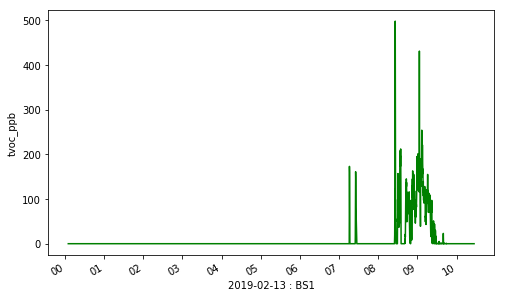

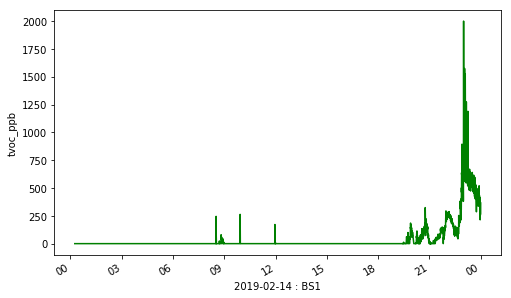

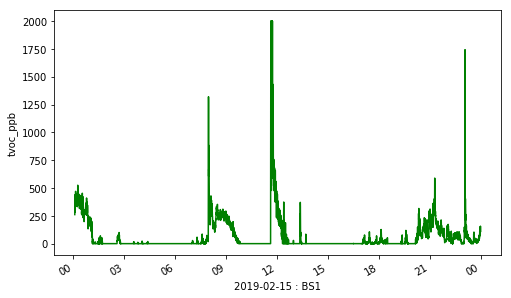

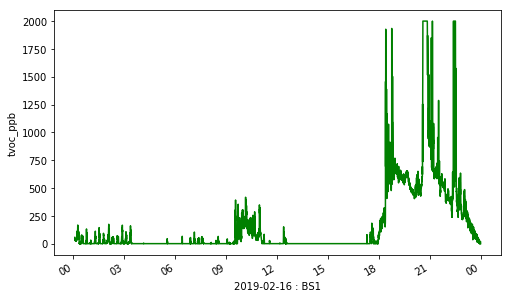

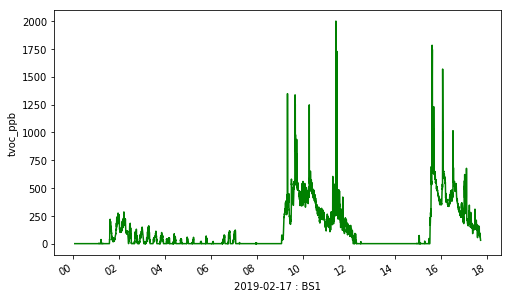

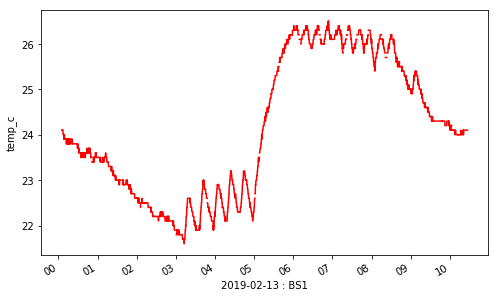

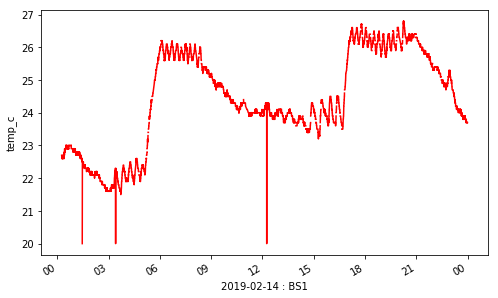

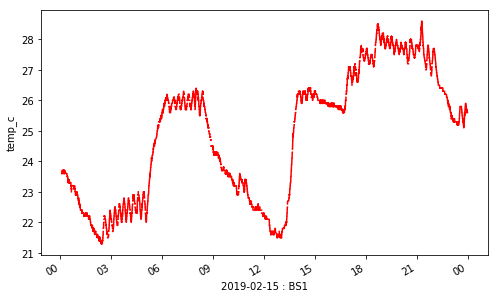

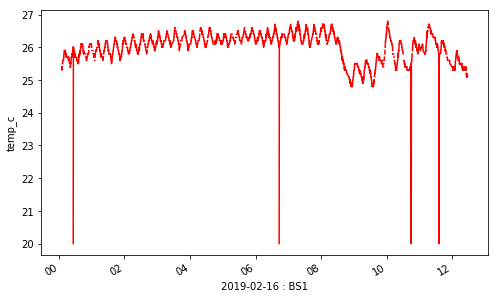

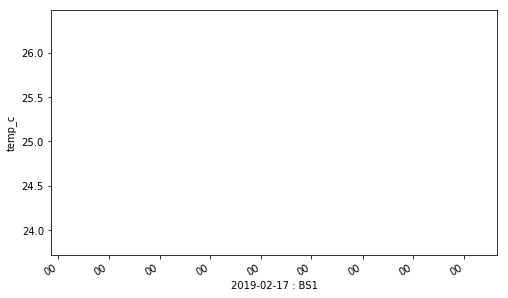

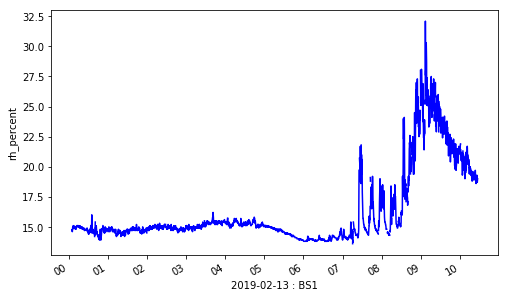

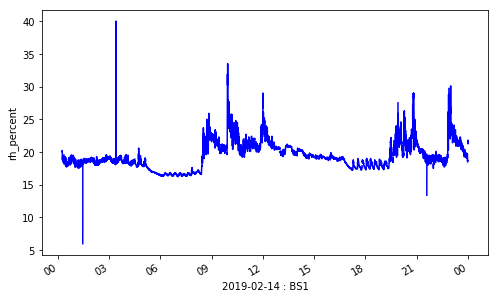

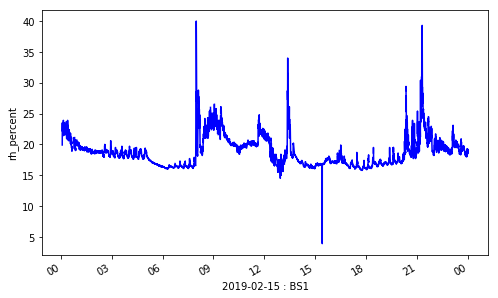

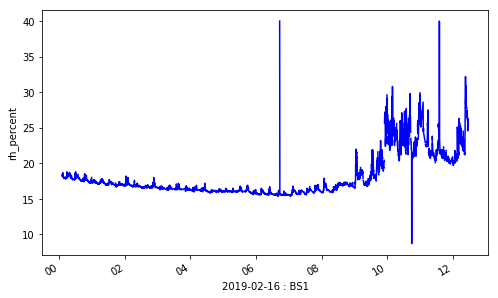

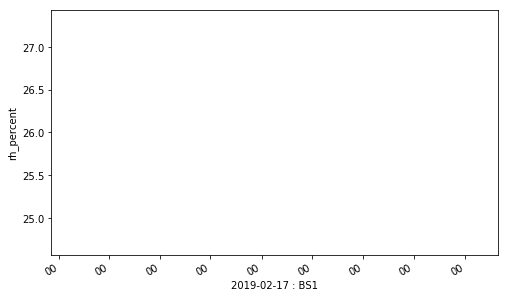

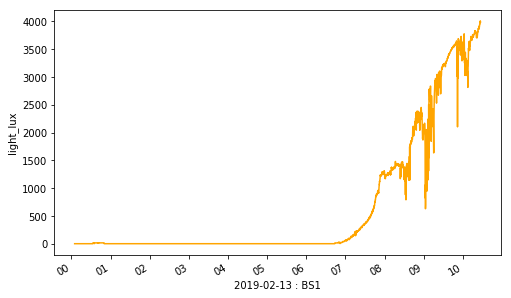

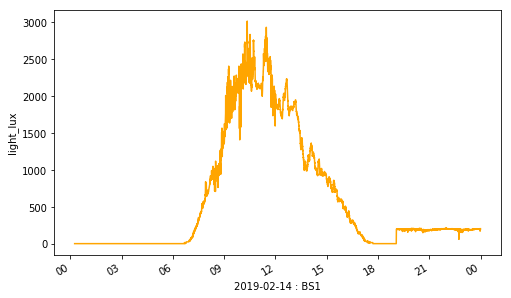

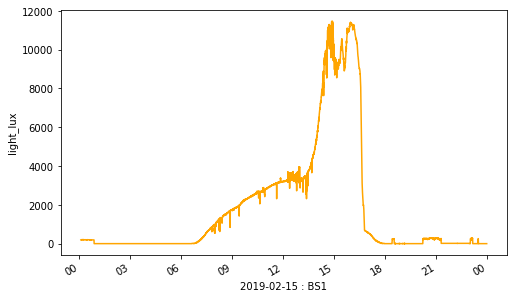

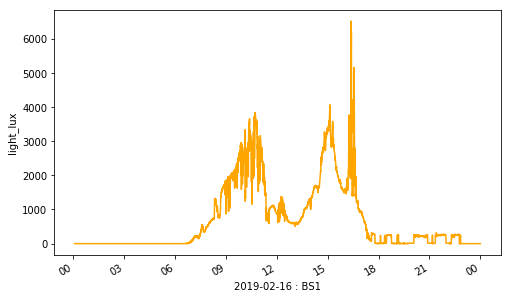

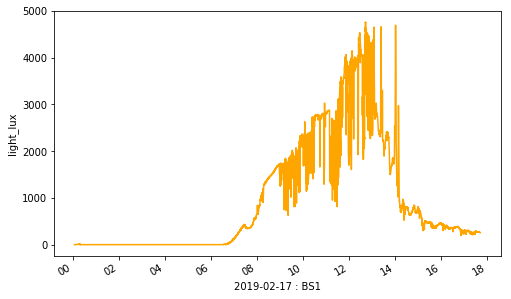

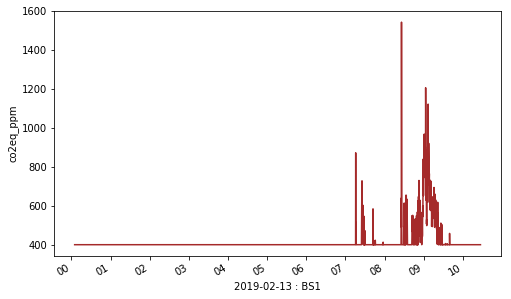

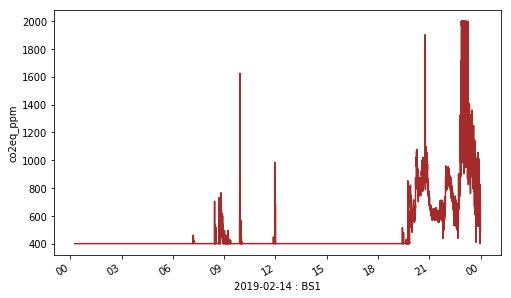

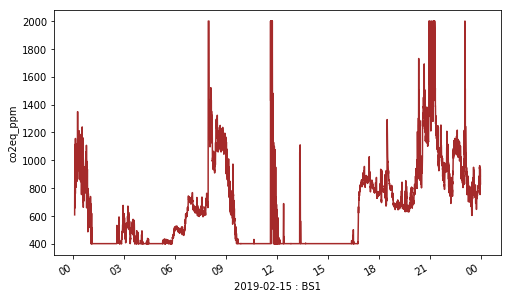

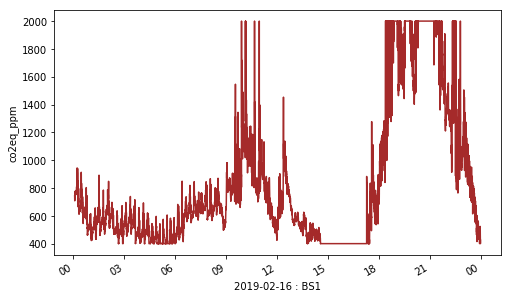

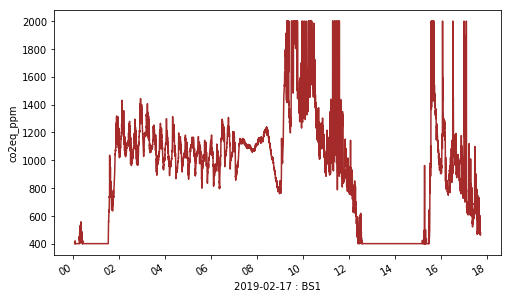

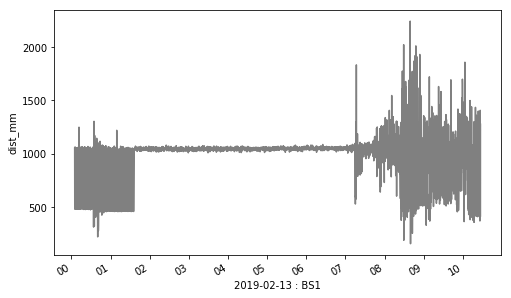

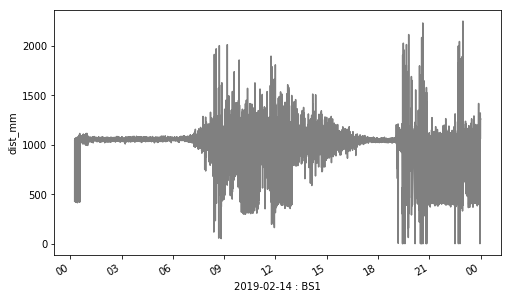

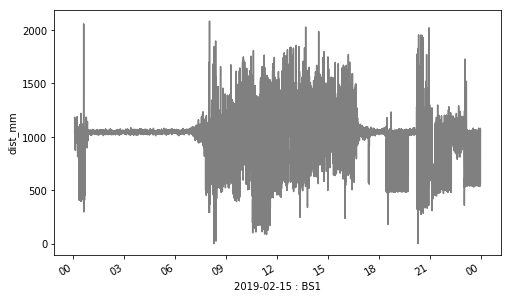

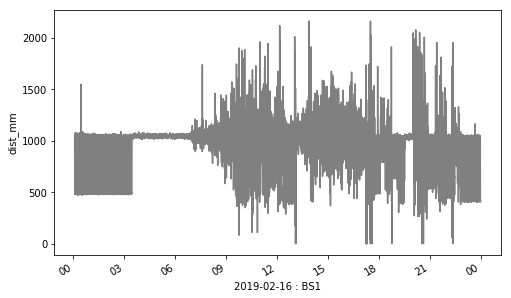

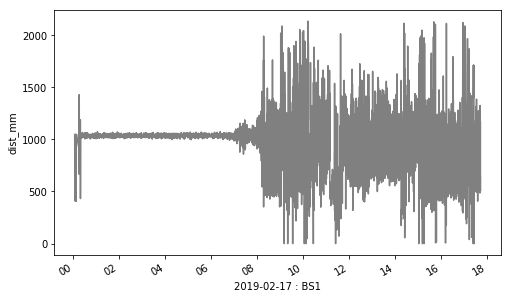

BS2


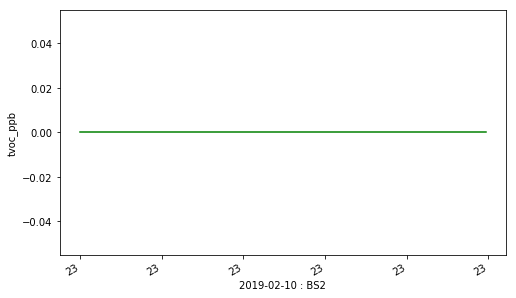

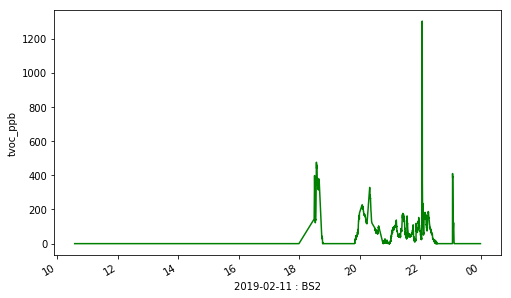

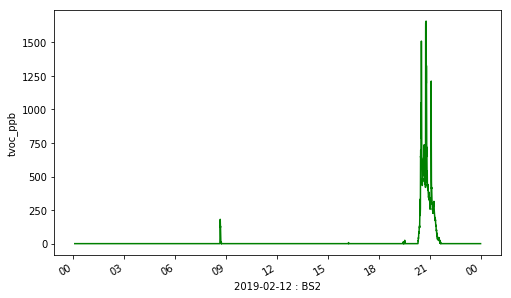

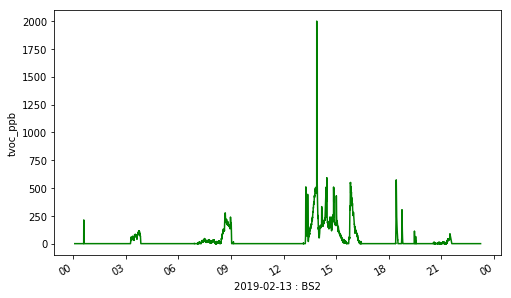

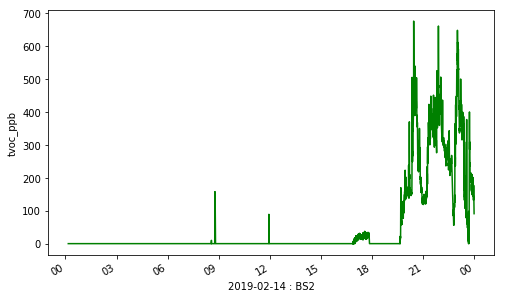

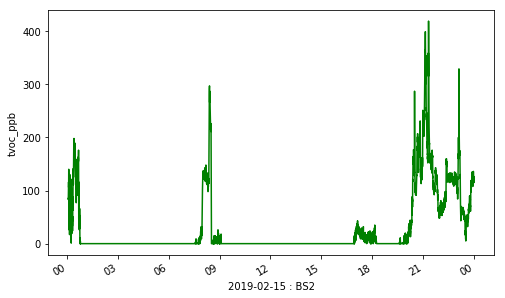

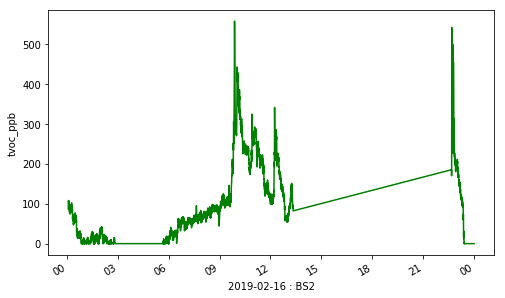

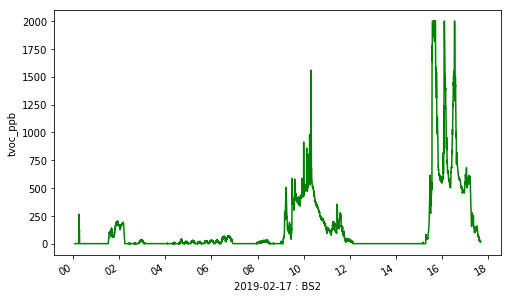

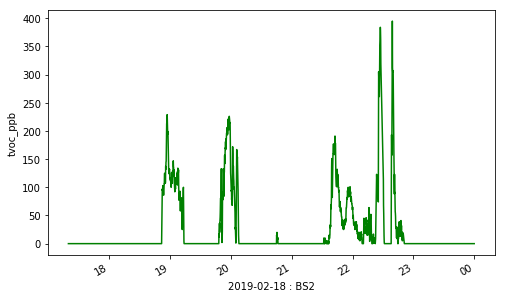

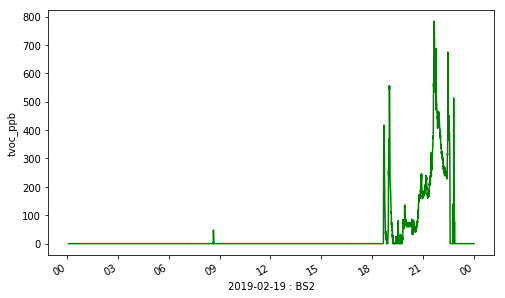

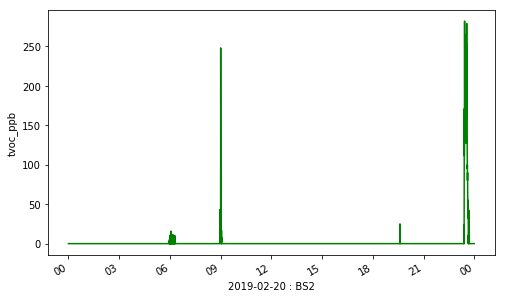

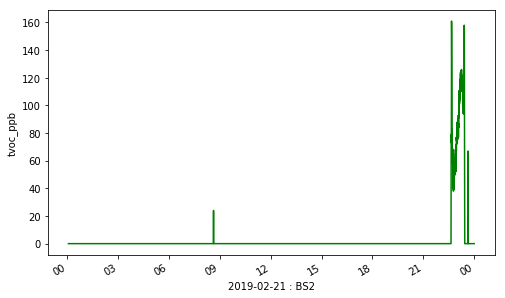

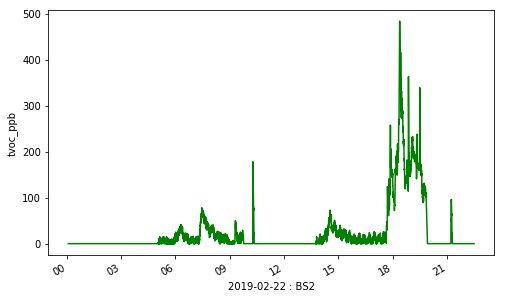

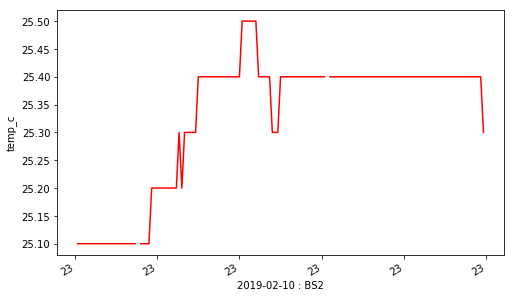

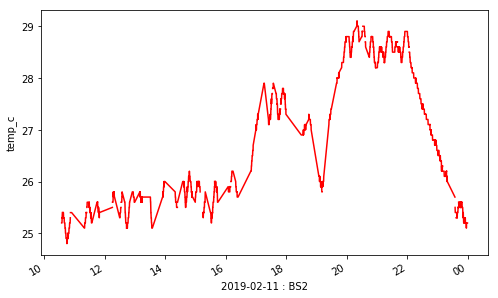

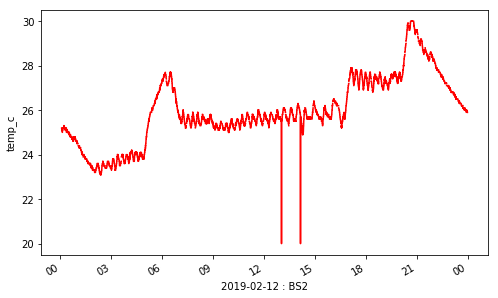

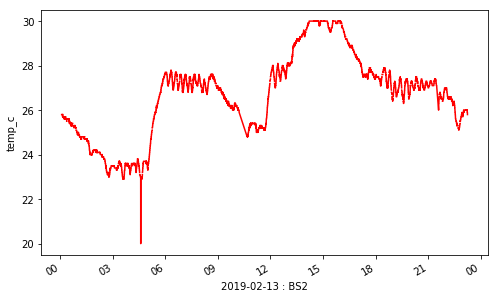

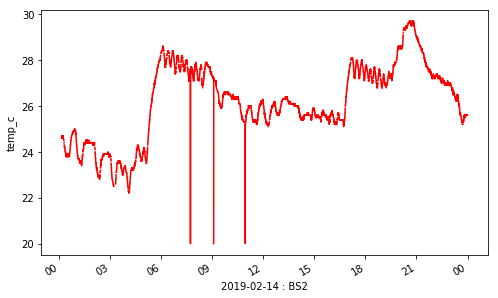

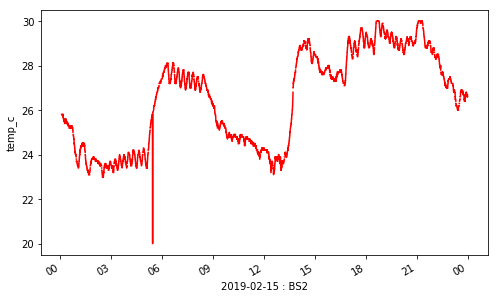

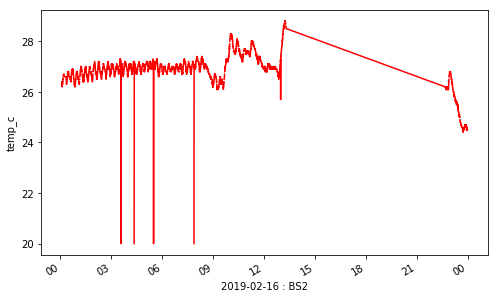

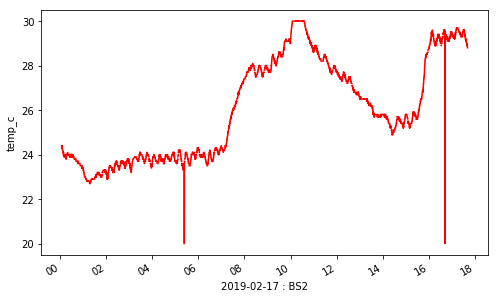

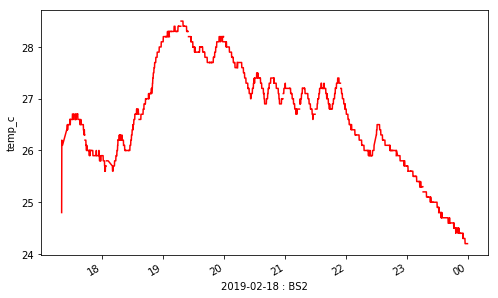

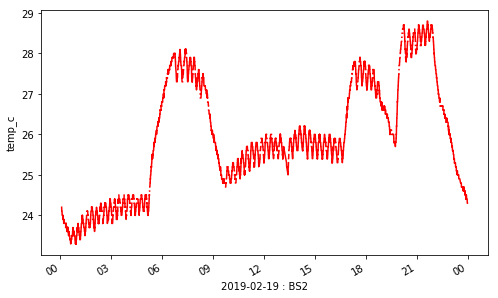

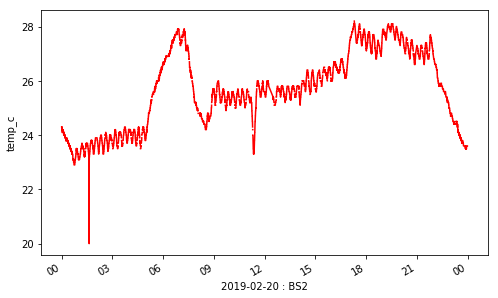

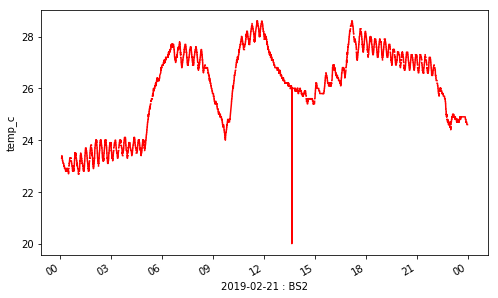

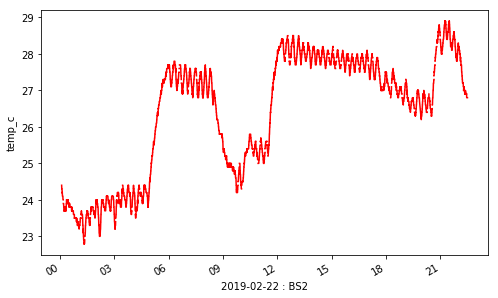

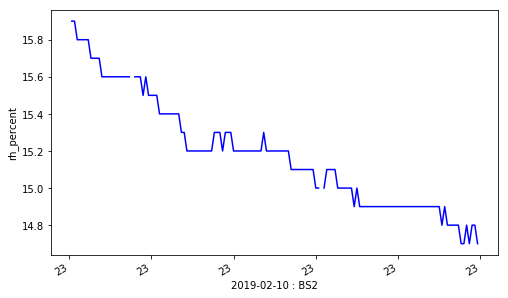

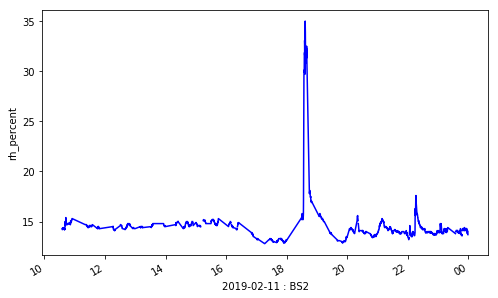

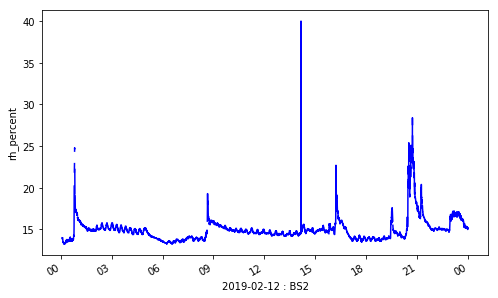

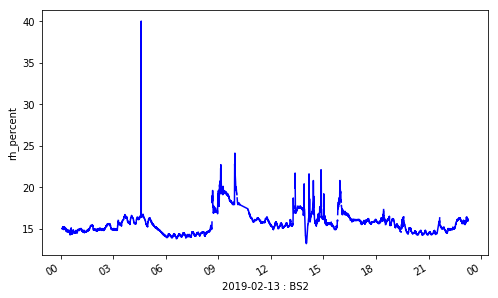

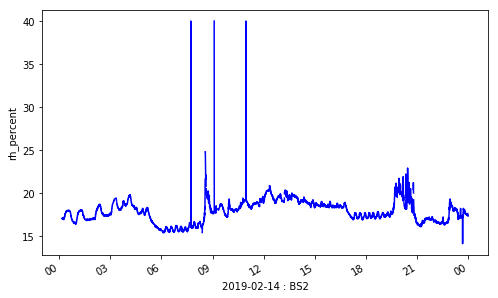

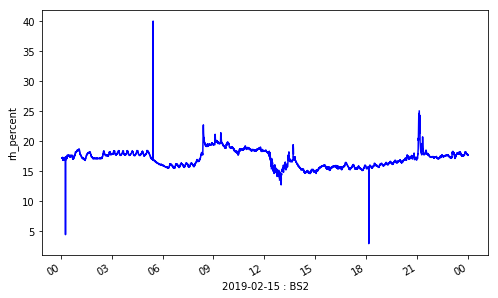

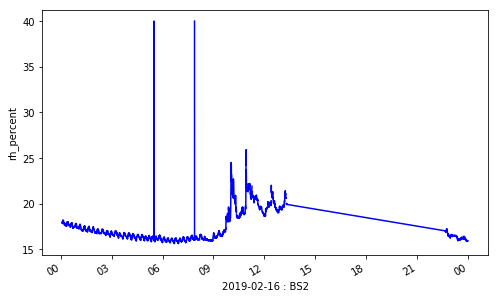

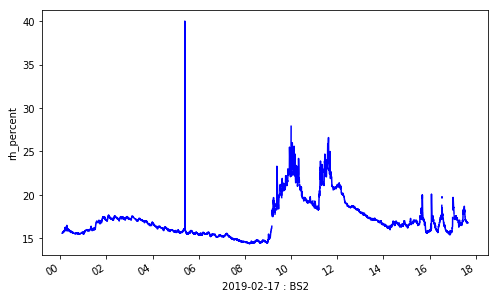

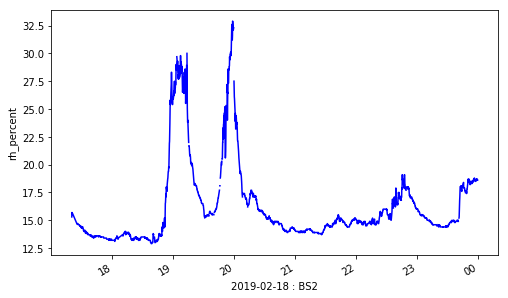

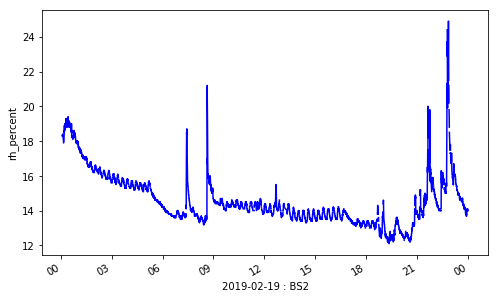

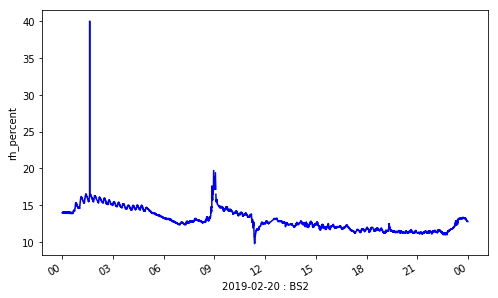

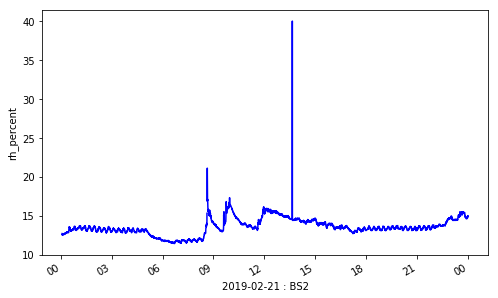

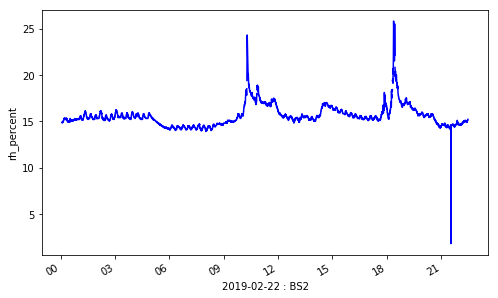

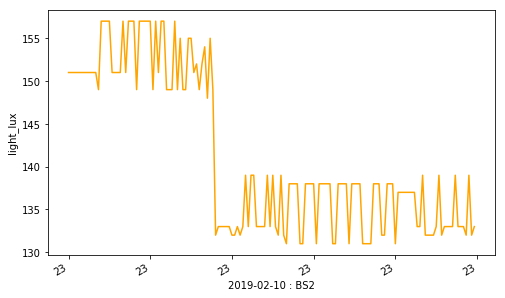

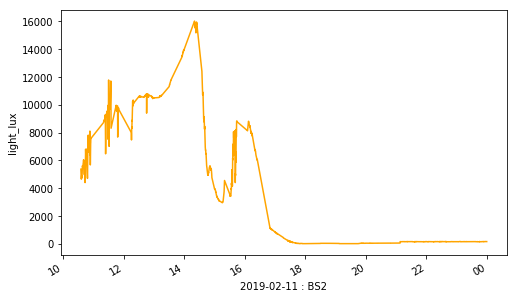

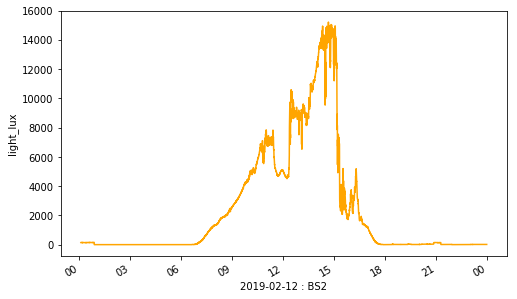

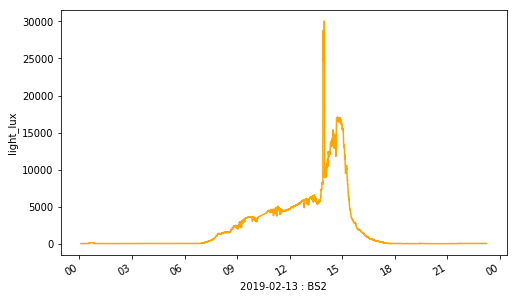

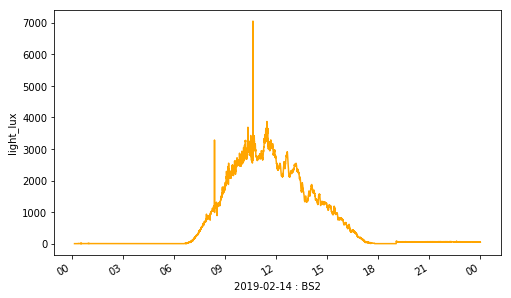

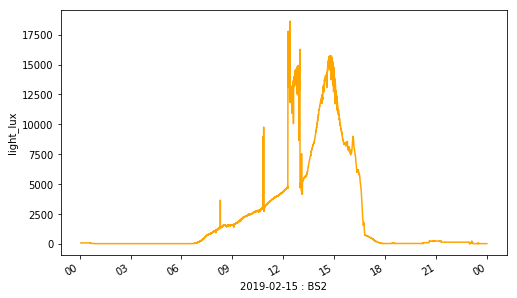

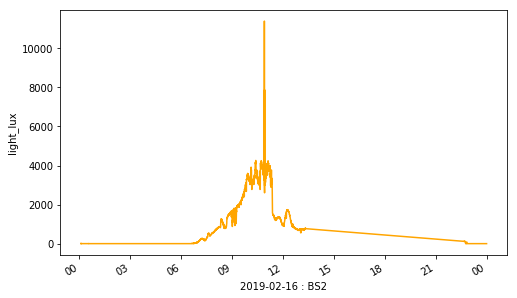

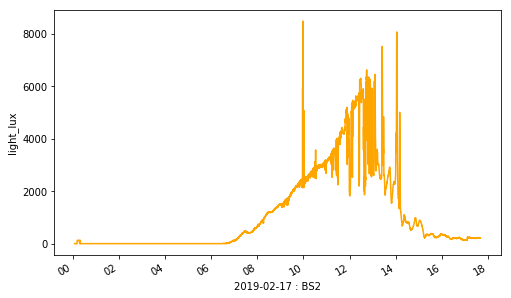

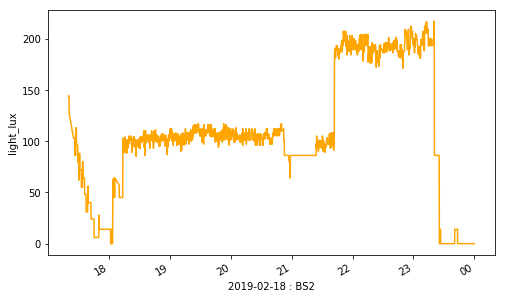

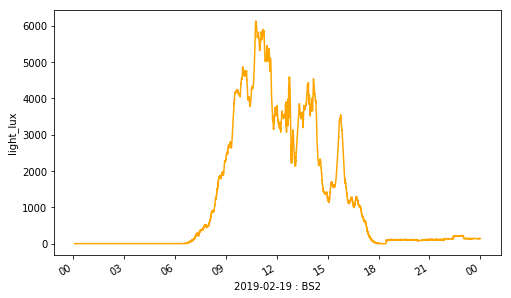

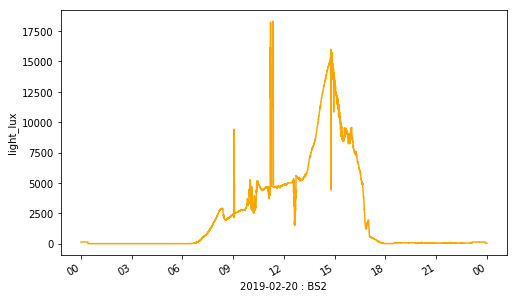

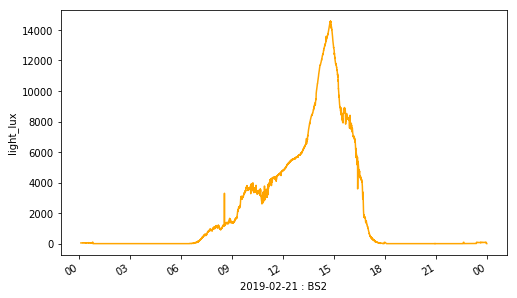

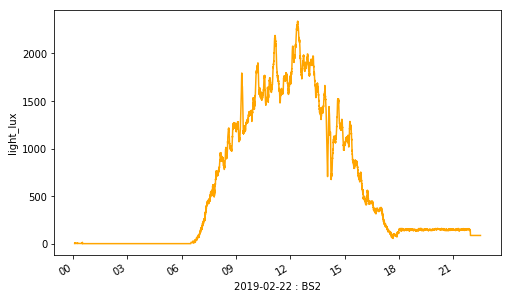

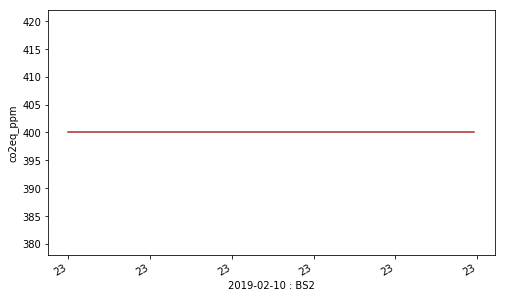

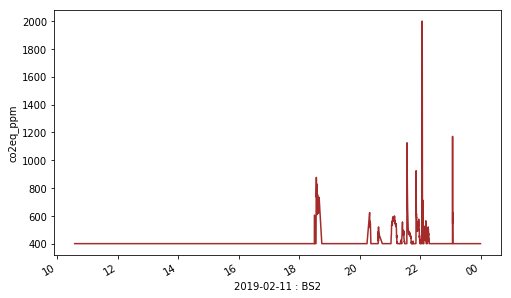

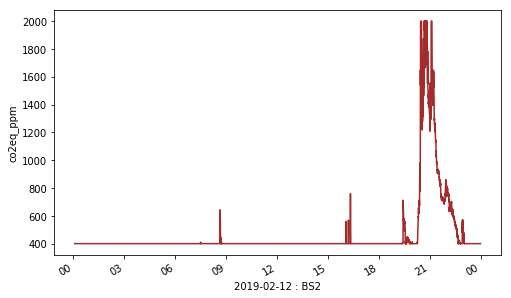

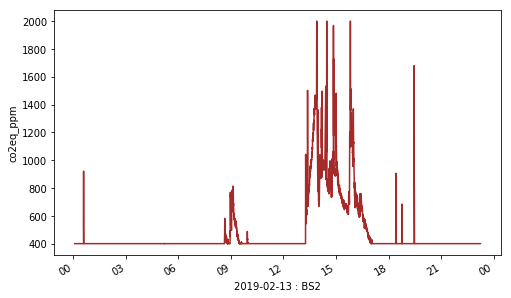

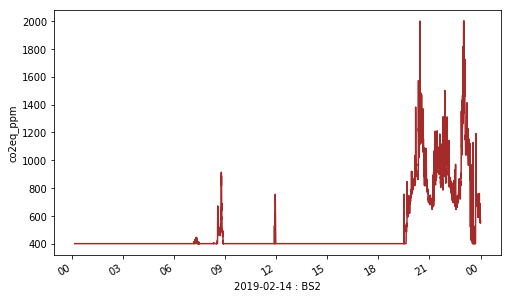

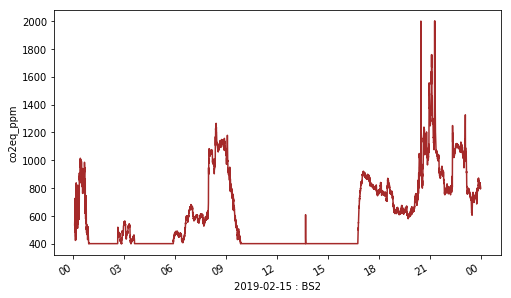

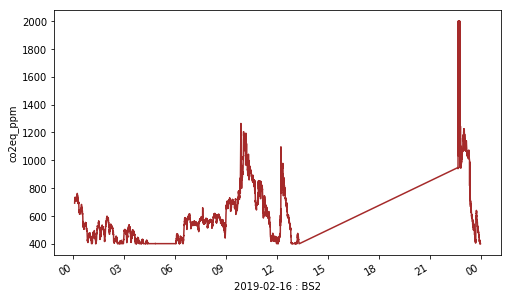

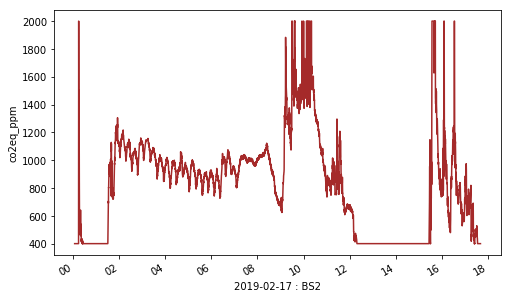

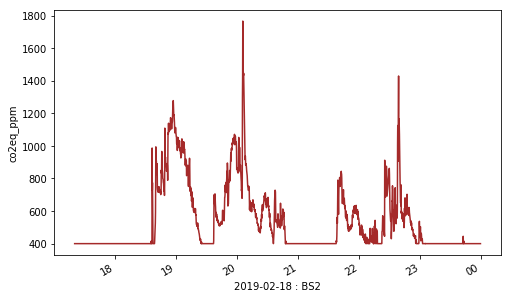

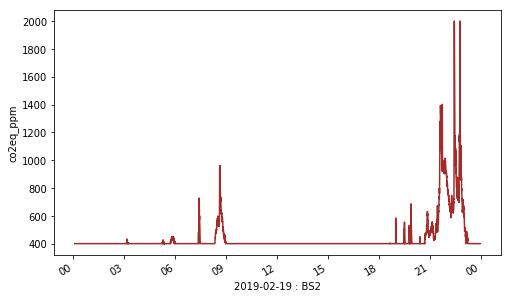

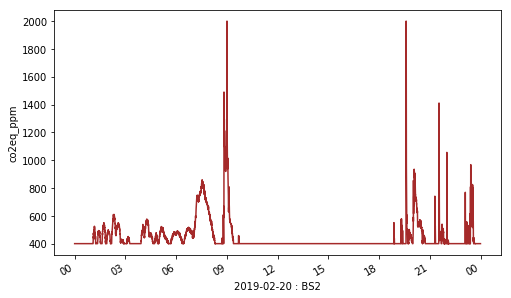

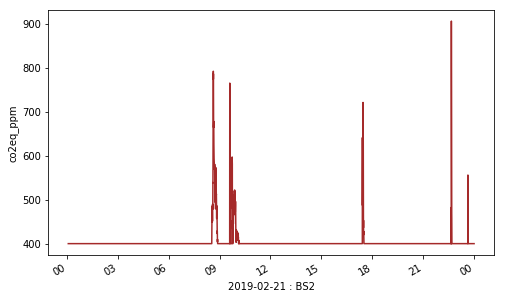

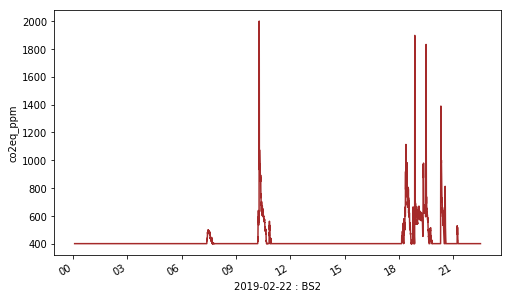

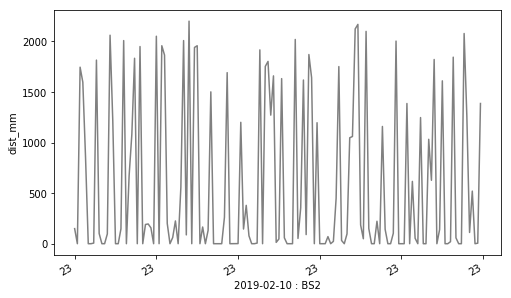

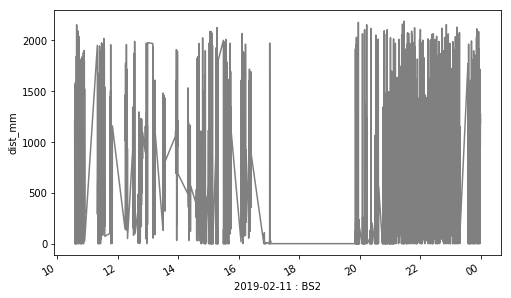

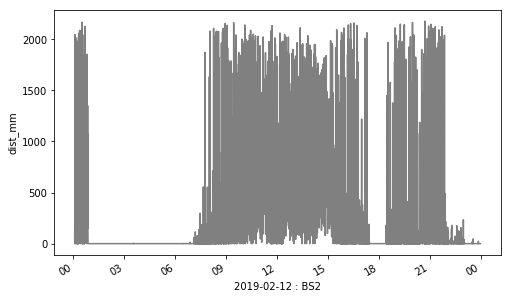

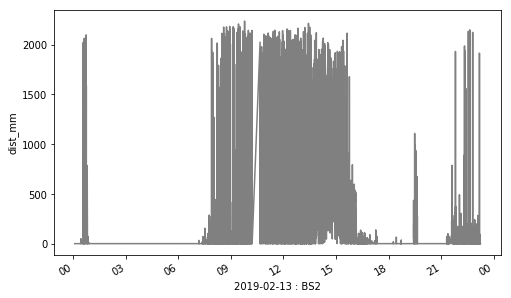

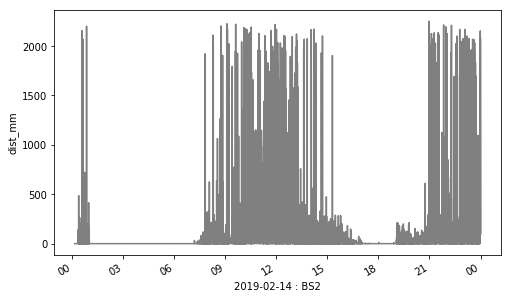

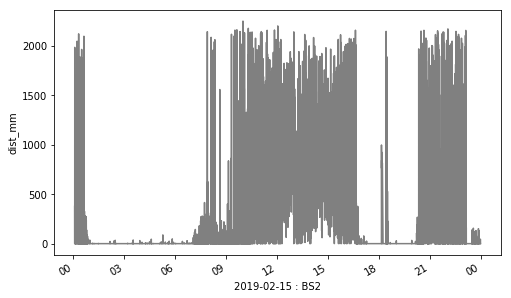

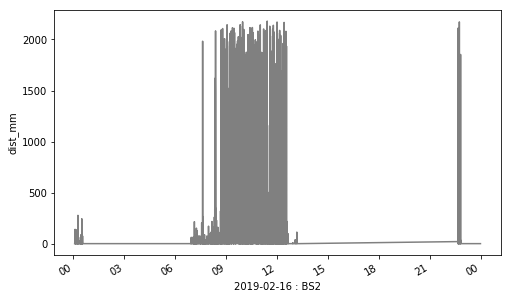

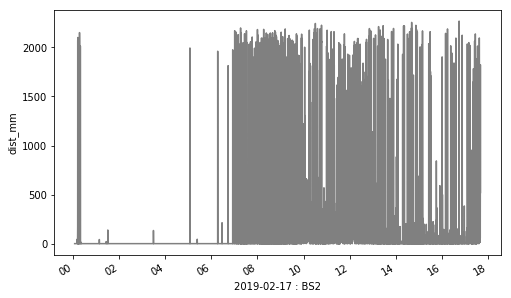

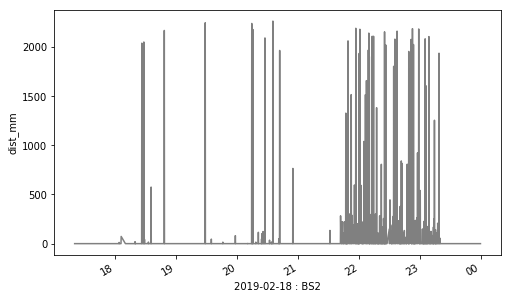

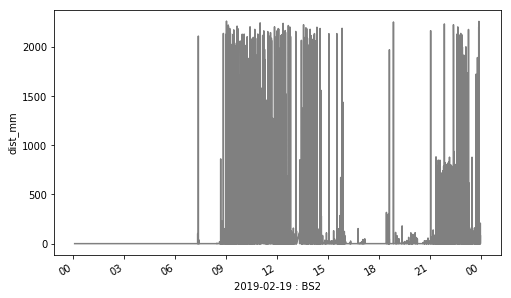

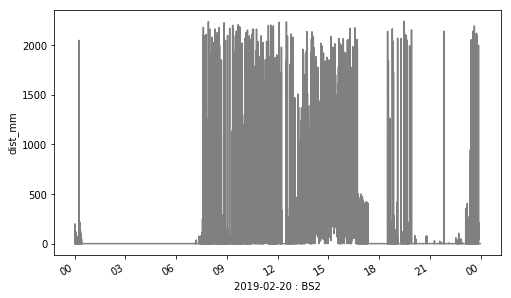

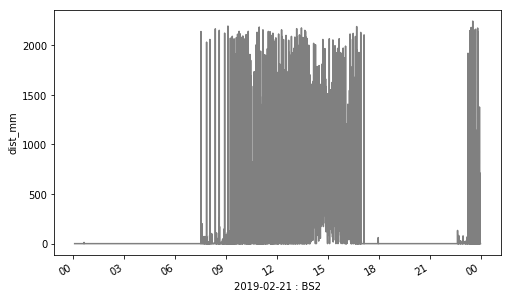

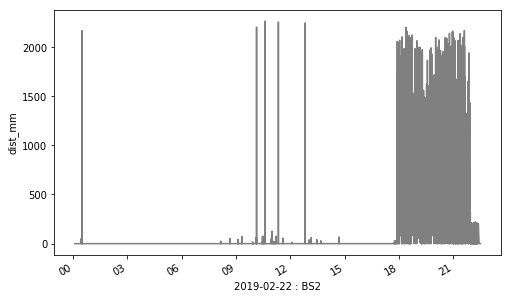

BS3


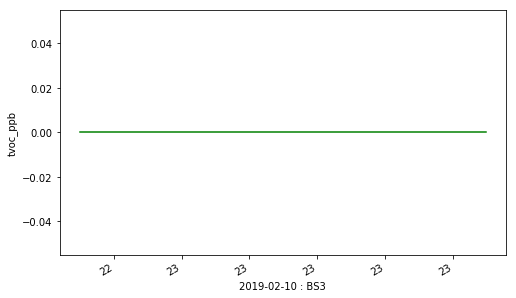

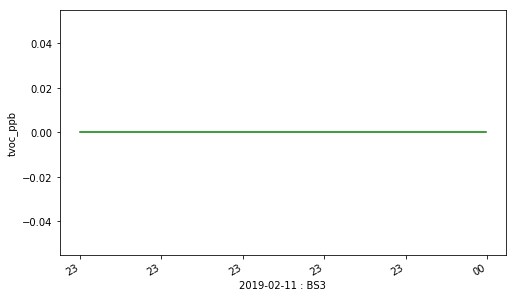

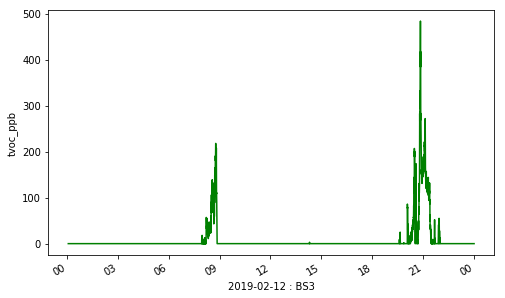

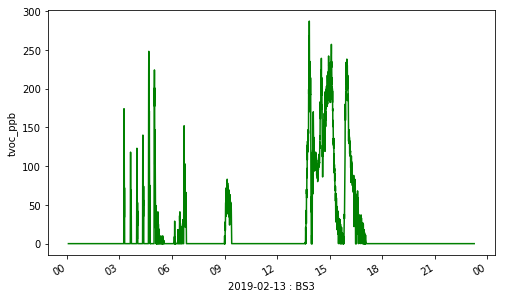

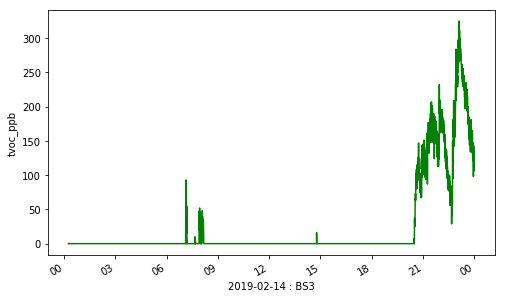

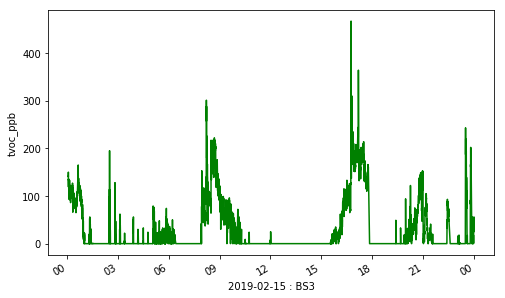

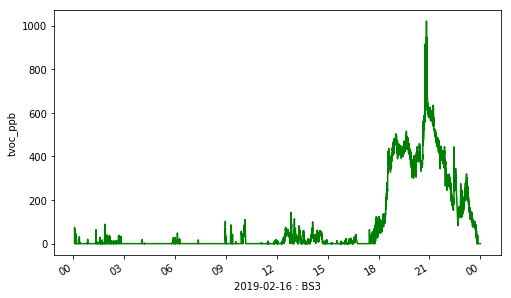

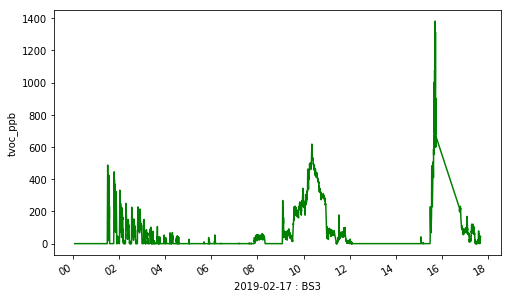

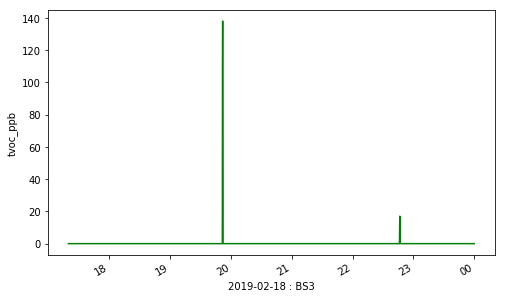

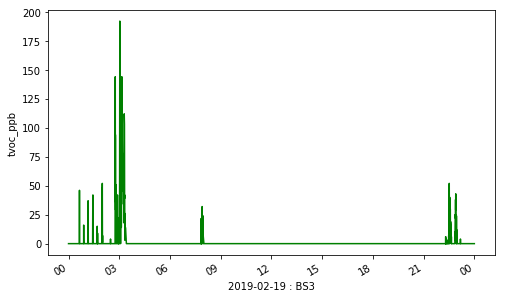

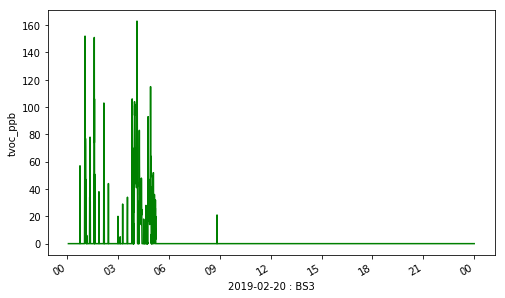

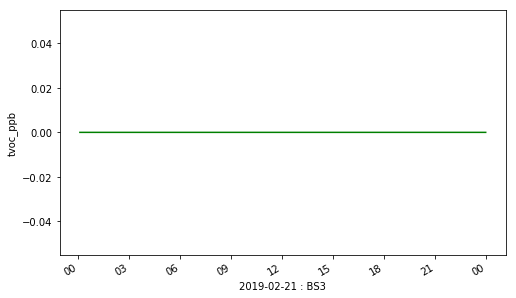

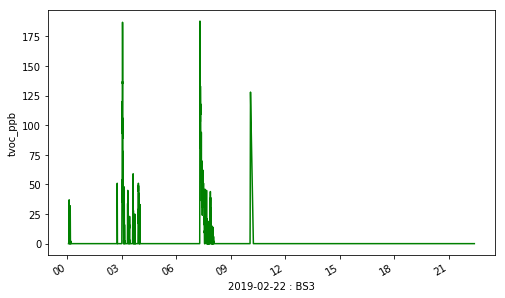

ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 576x360 with 1 Axes>

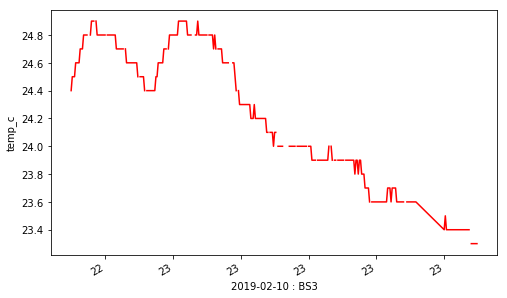

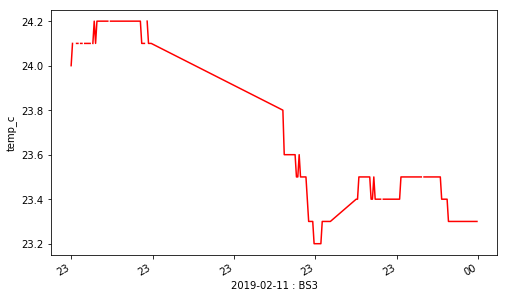

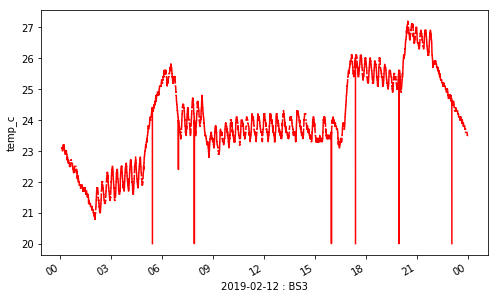

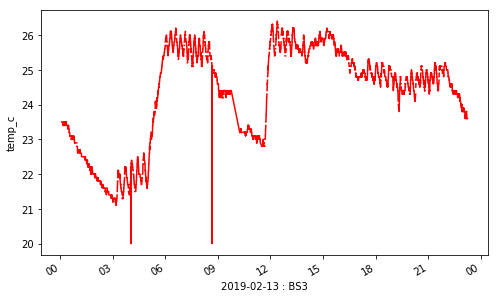

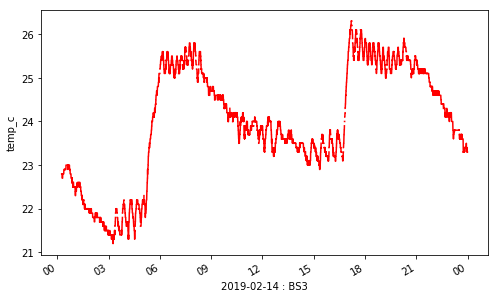

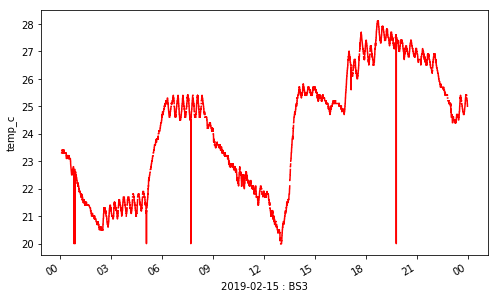

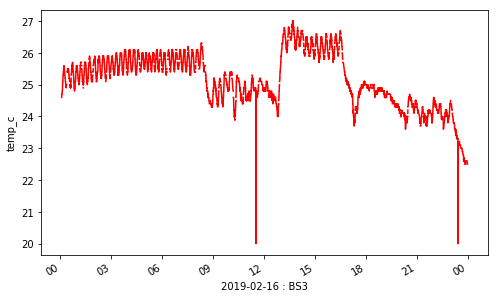

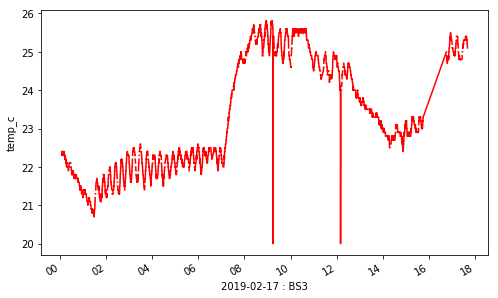

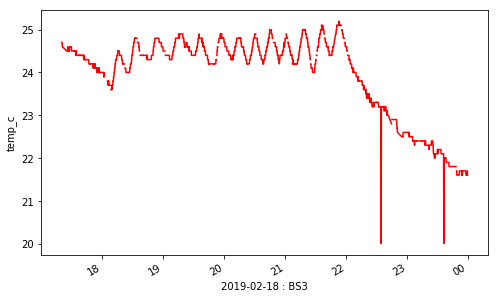

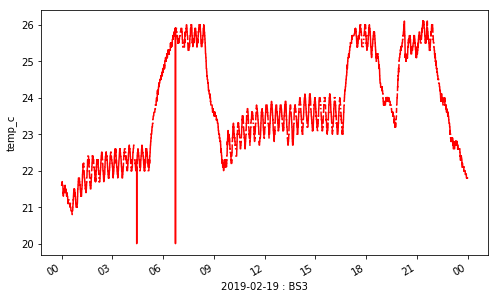

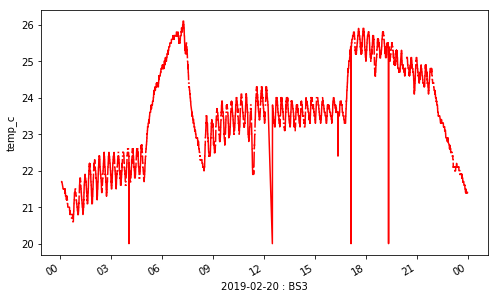

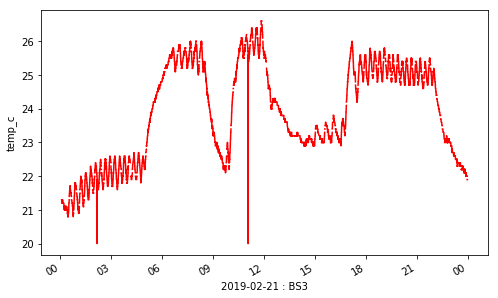

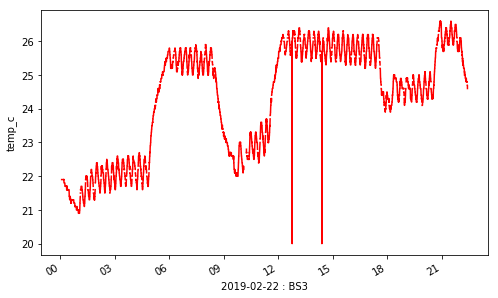

ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 576x360 with 1 Axes>

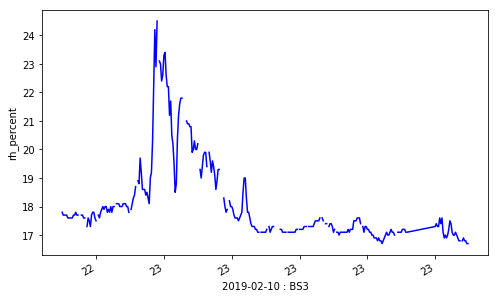

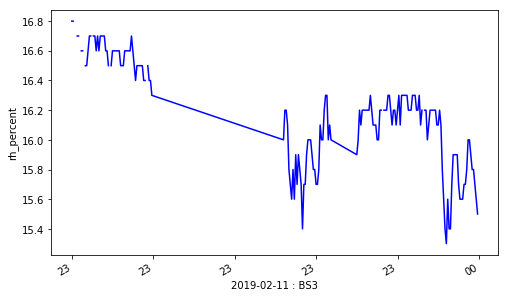

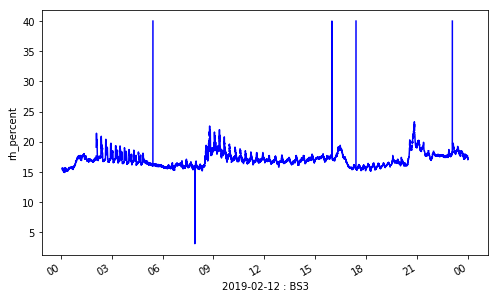

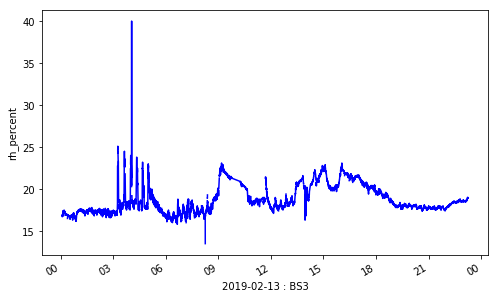

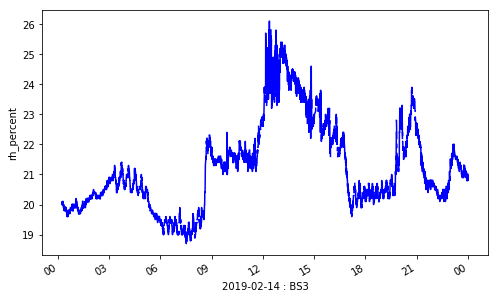

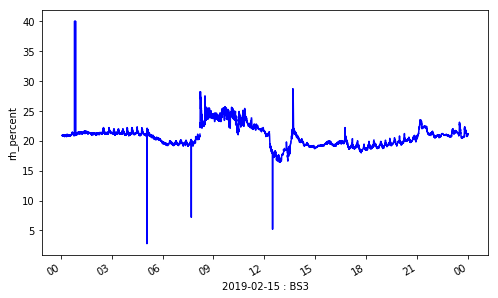

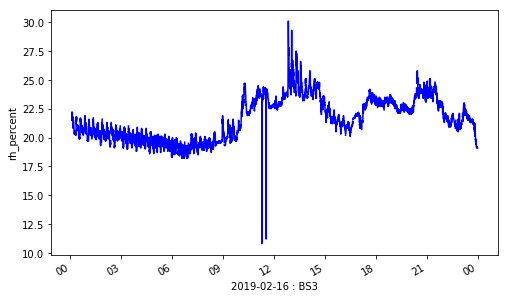

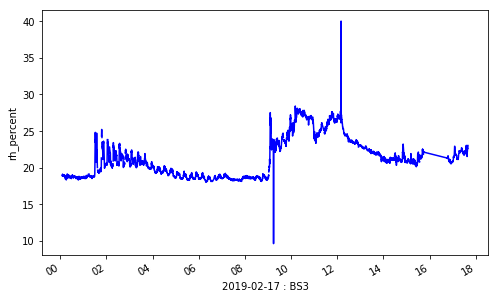

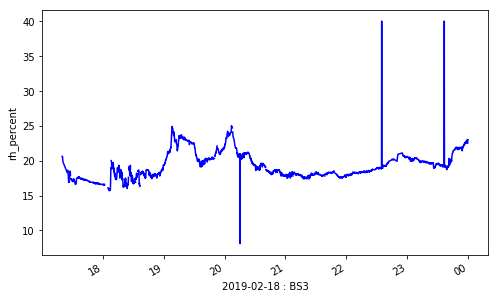

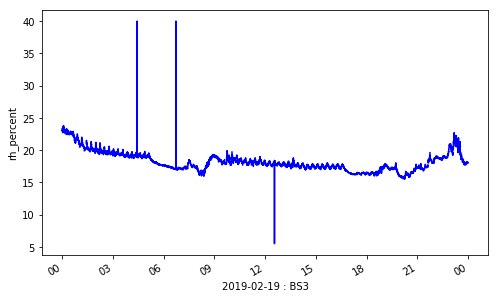

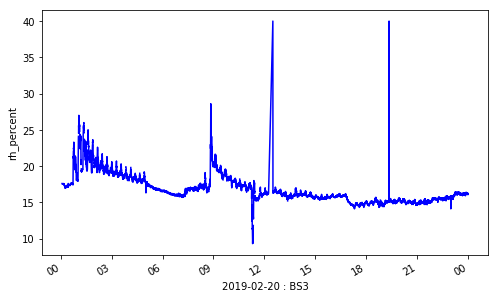

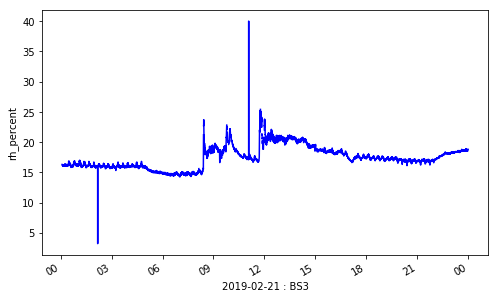

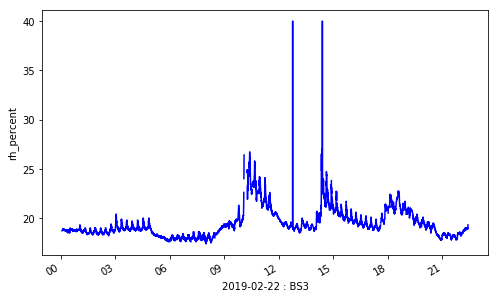

ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 576x360 with 1 Axes>

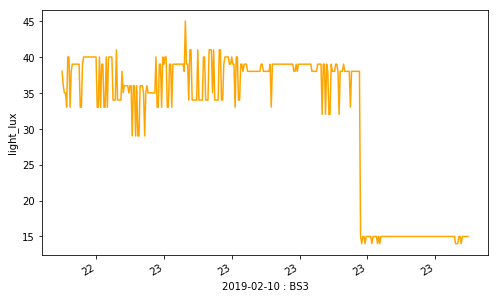

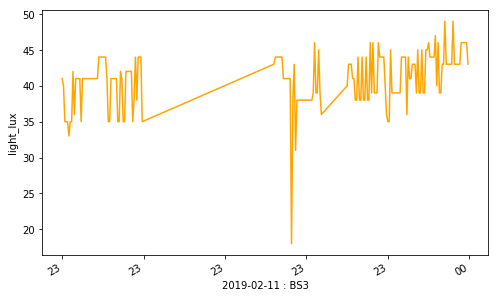

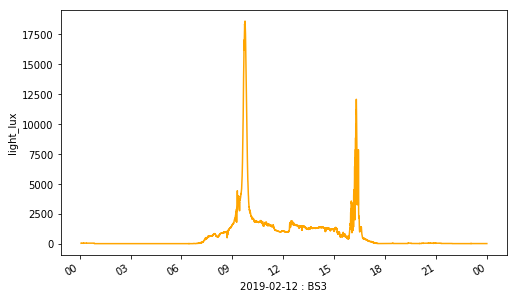

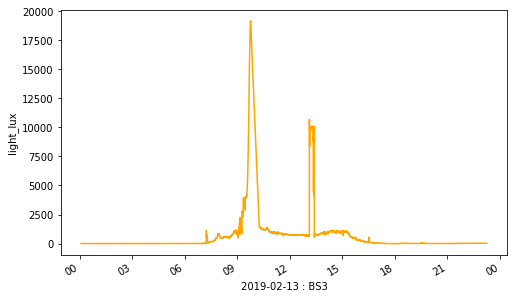

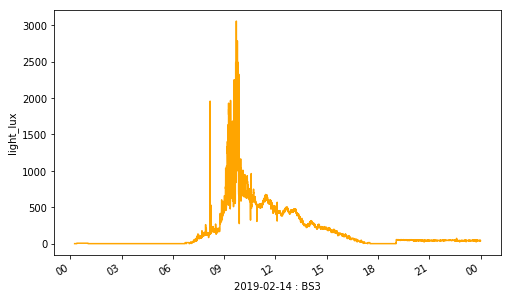

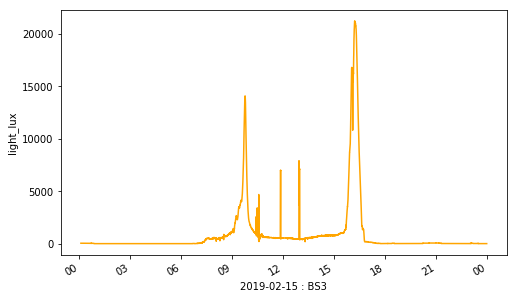

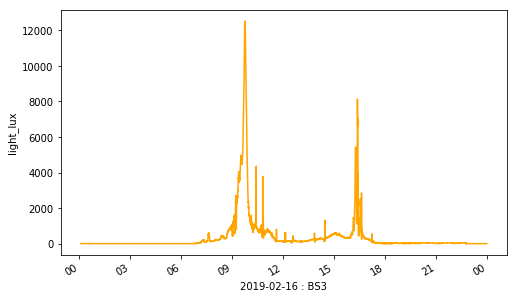

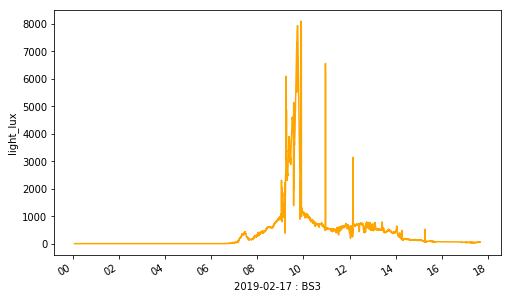

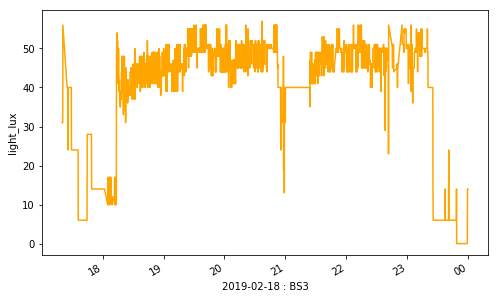

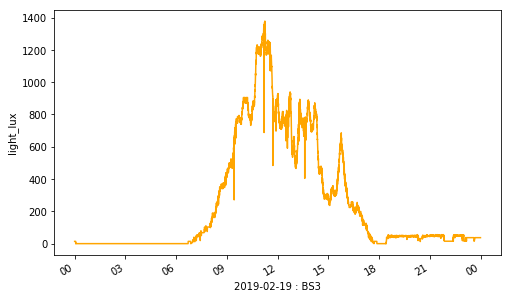

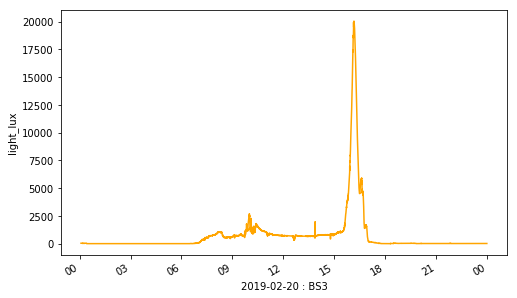

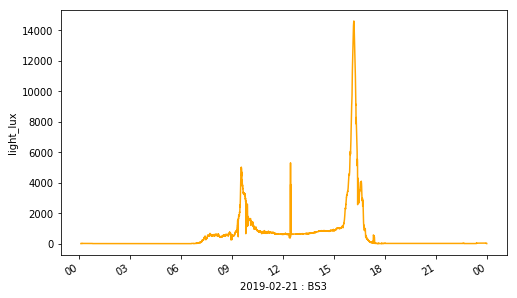

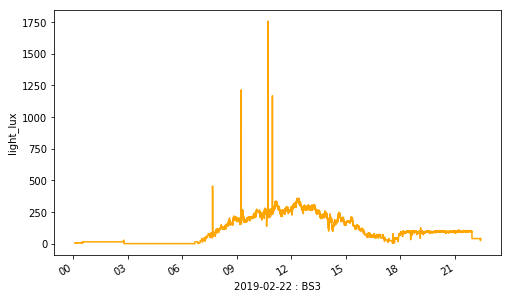

ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 576x360 with 1 Axes>

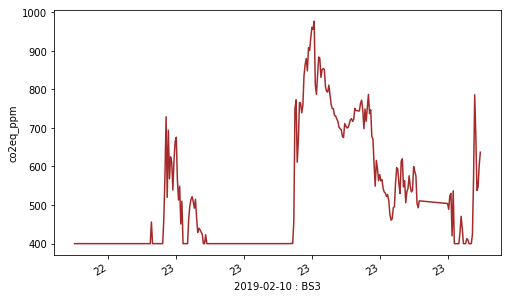

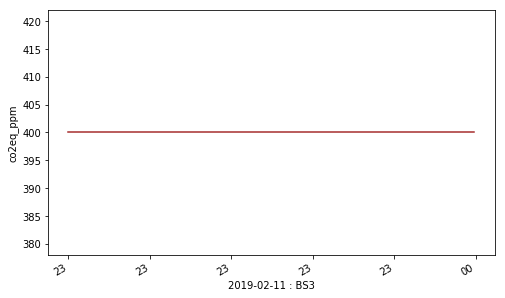

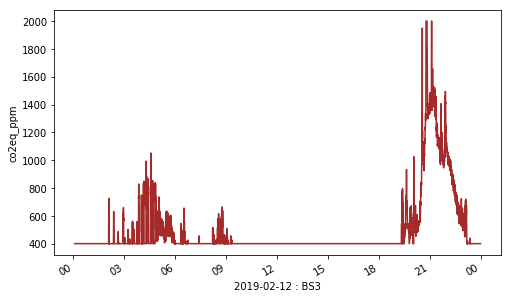

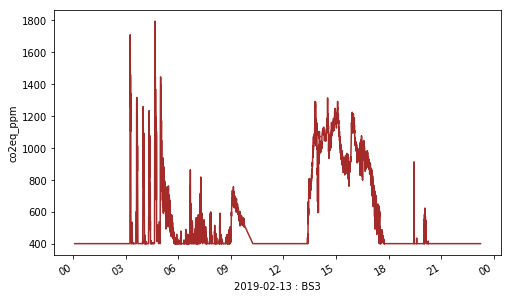

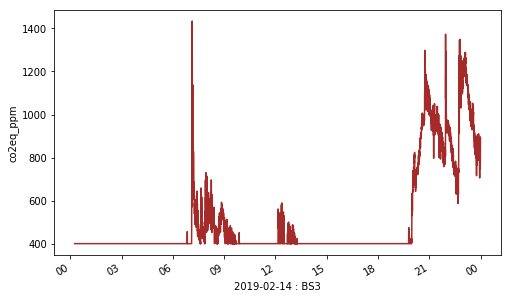

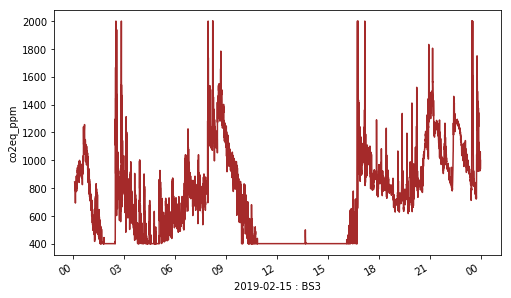

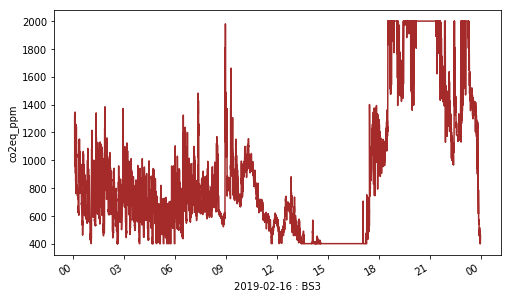

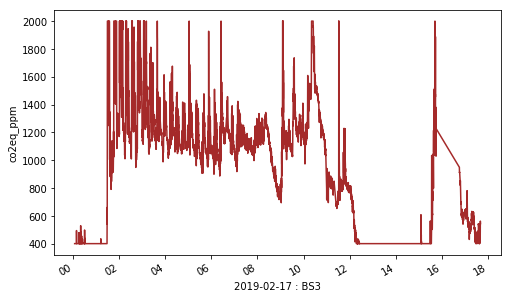

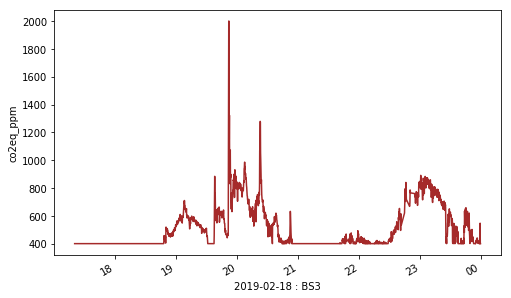

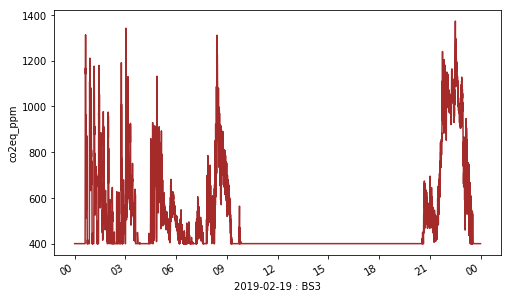

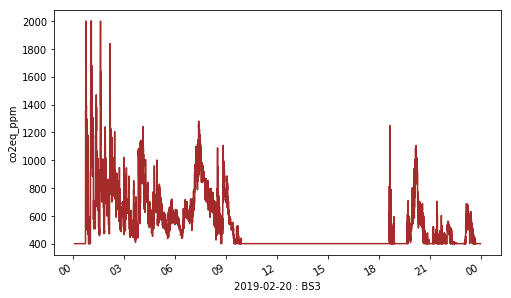

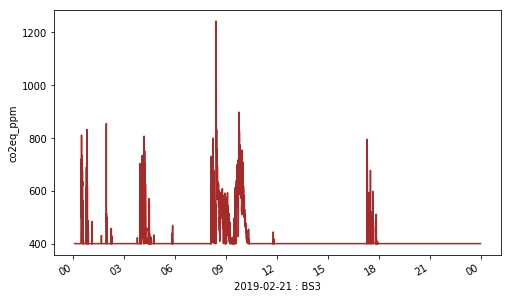

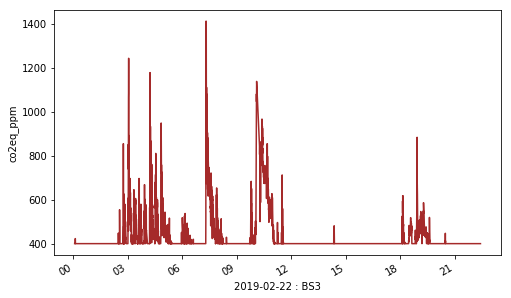

ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 576x360 with 1 Axes>

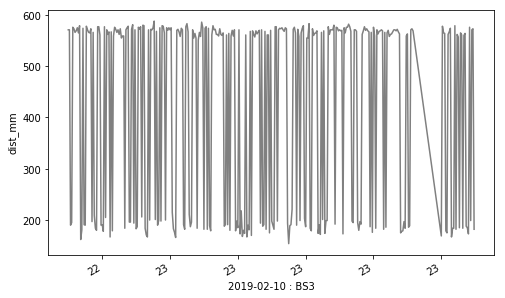

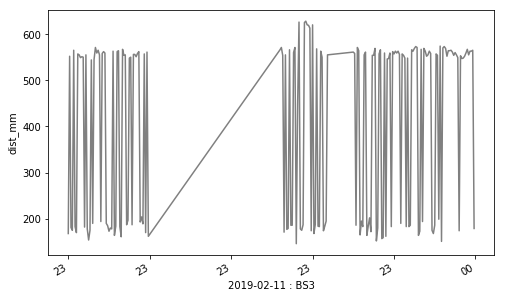

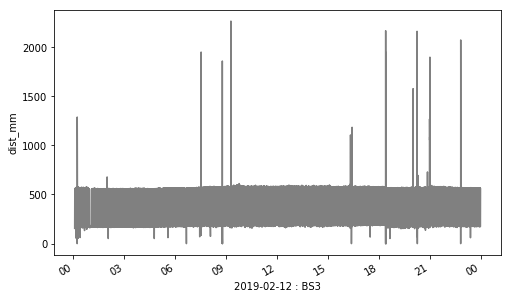

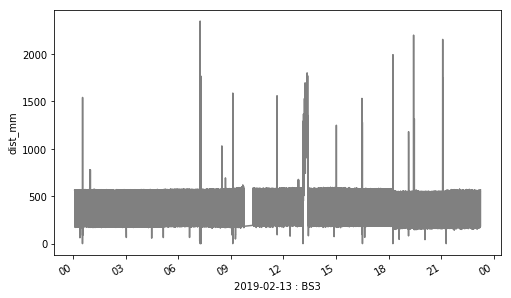

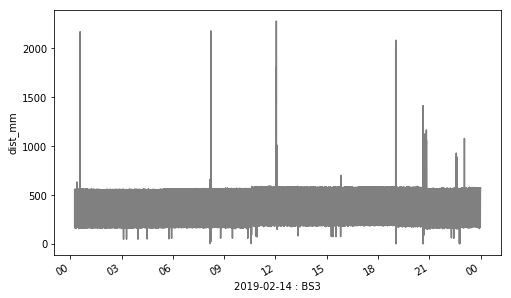

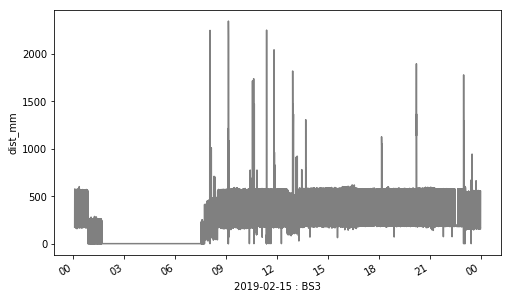

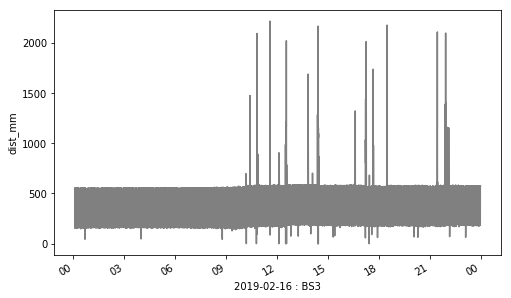

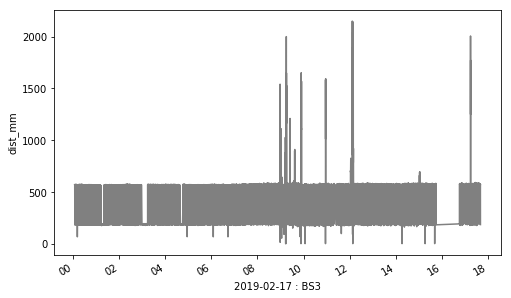

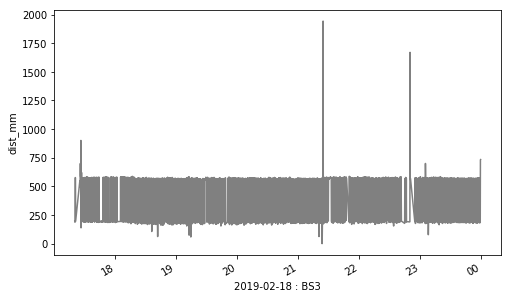

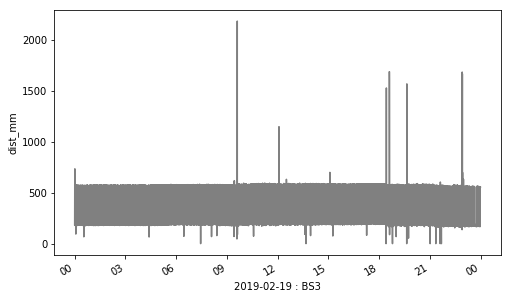

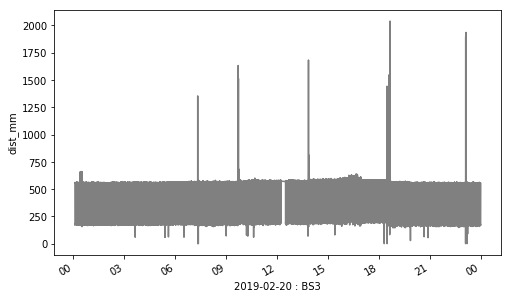

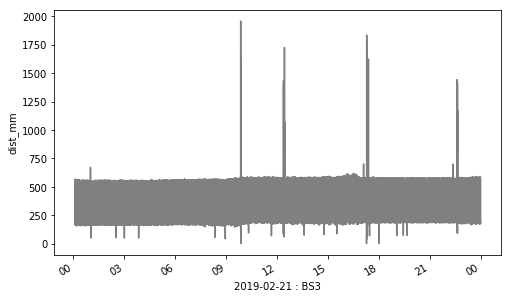

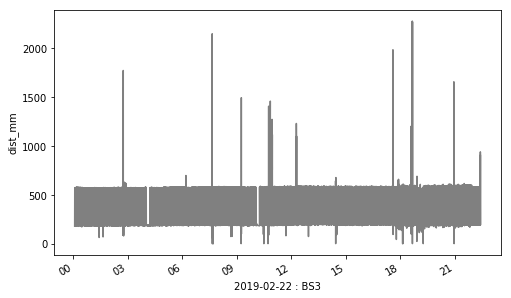

ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 576x360 with 1 Axes>

BS4


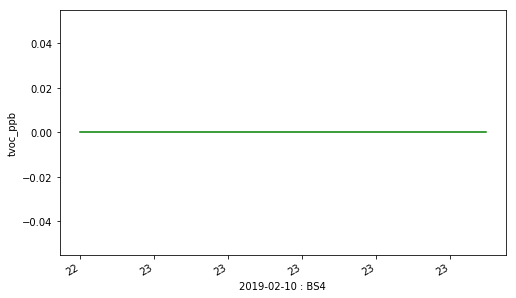

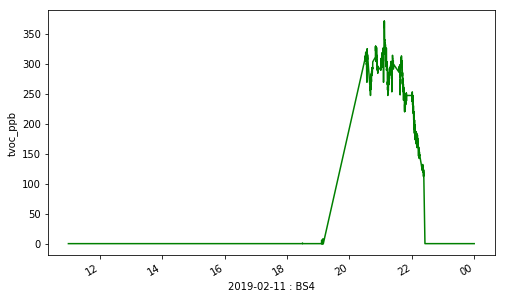

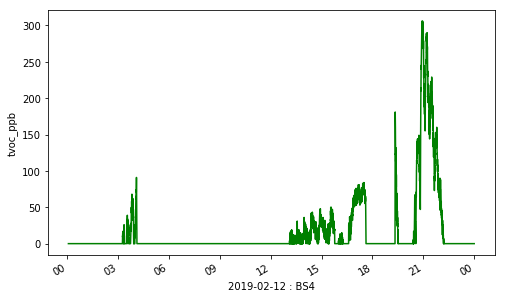

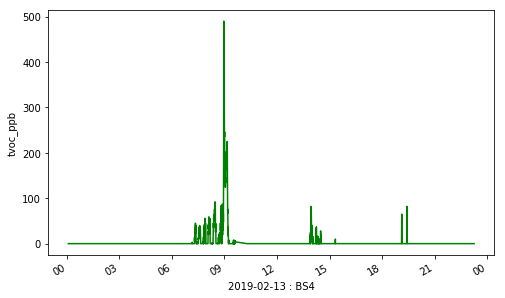

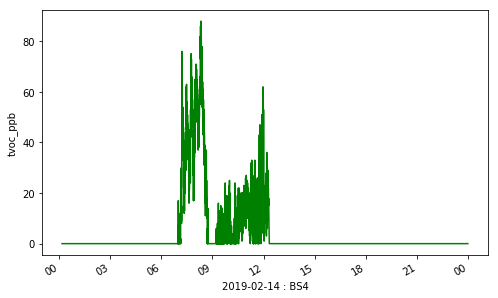

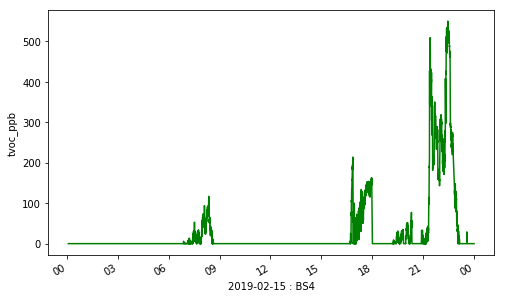

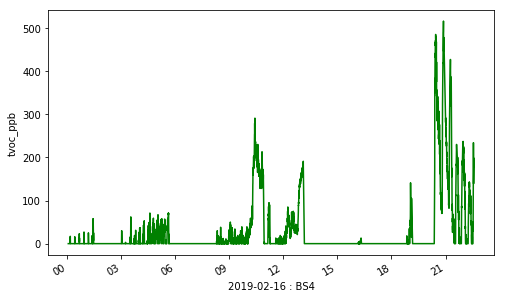

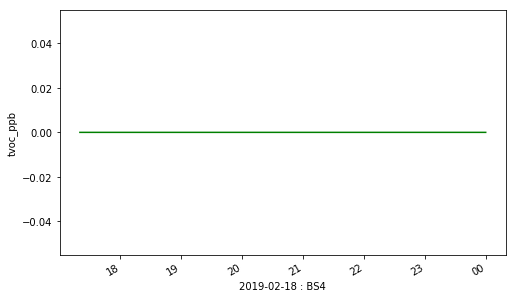

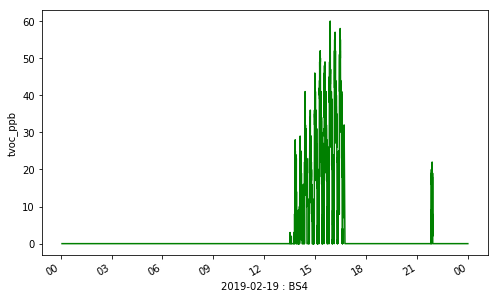

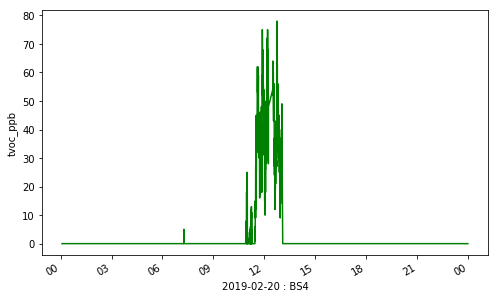

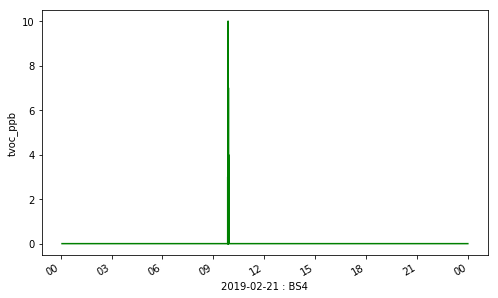

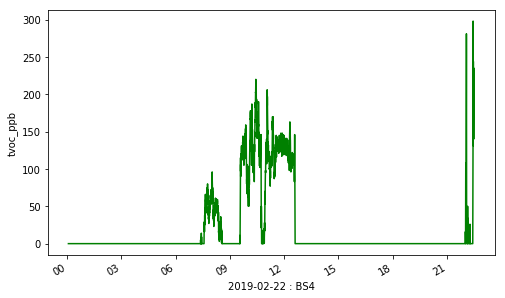

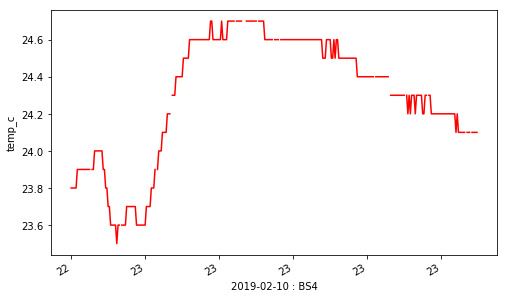

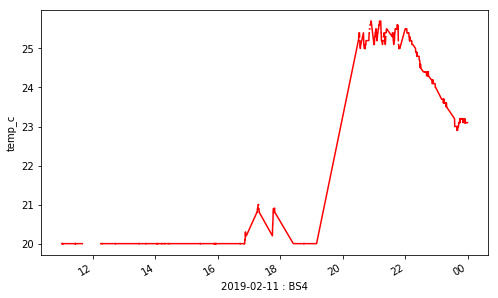

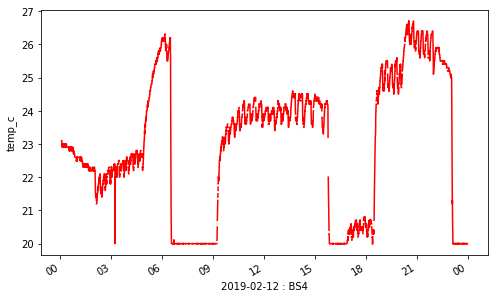

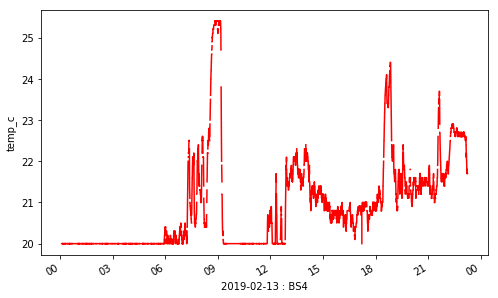

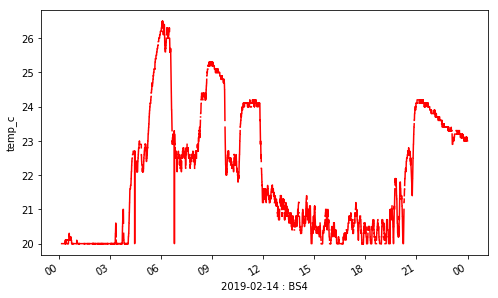

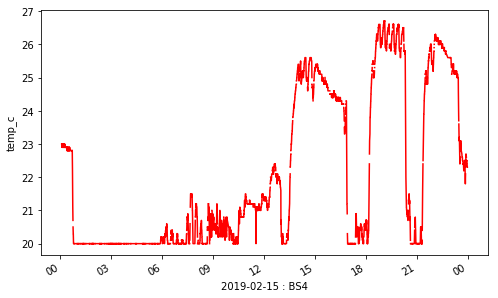

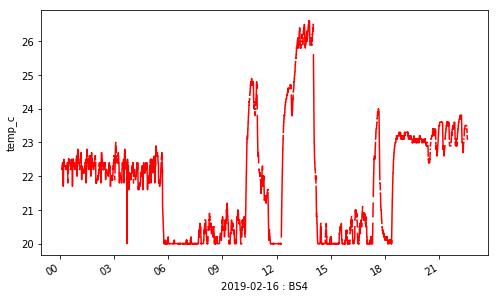

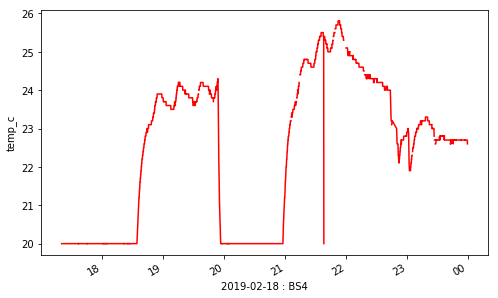

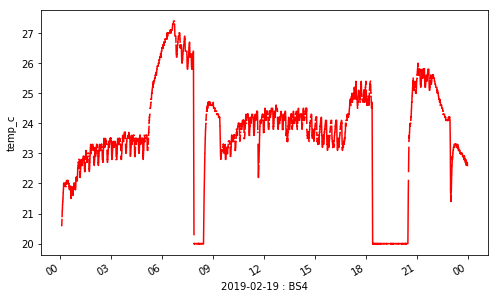

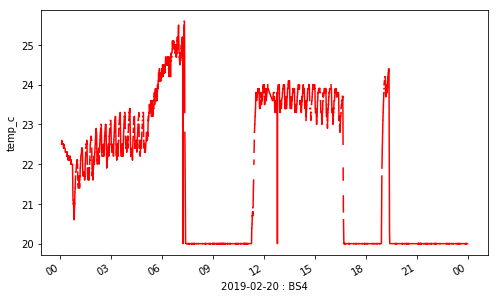

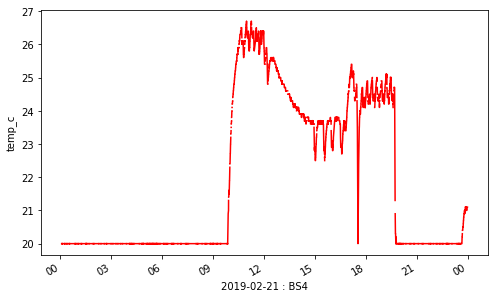

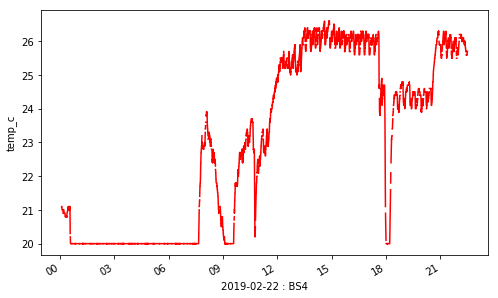

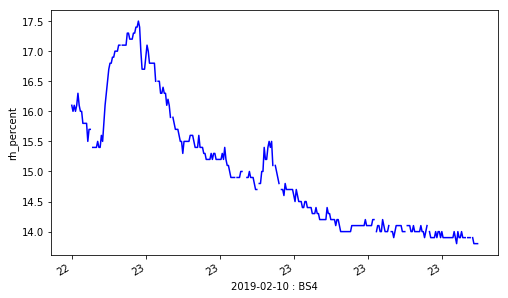

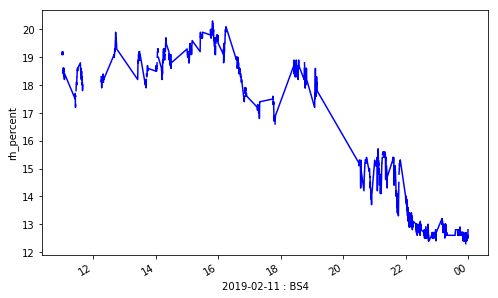

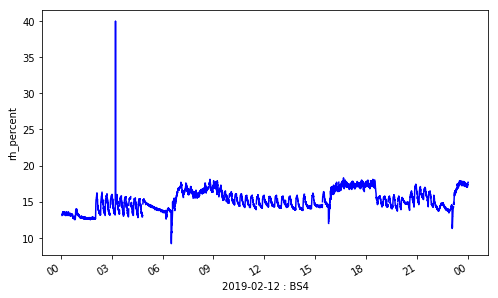

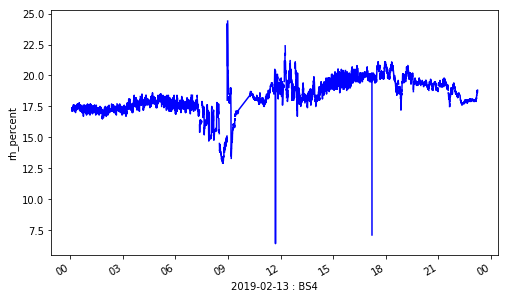

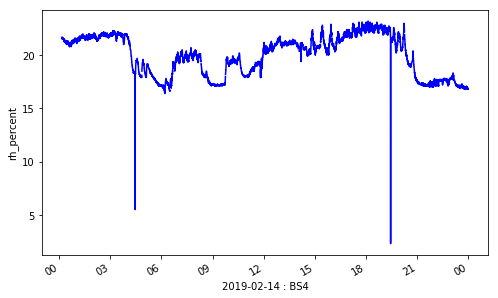

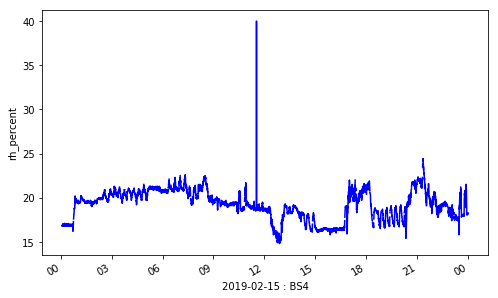

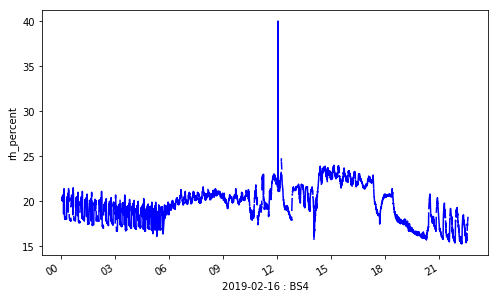

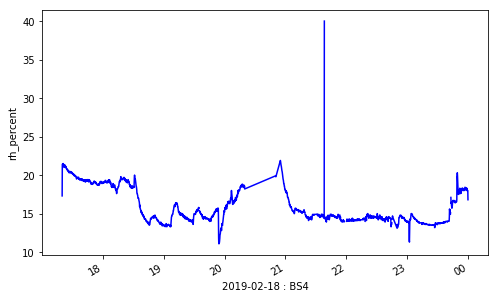

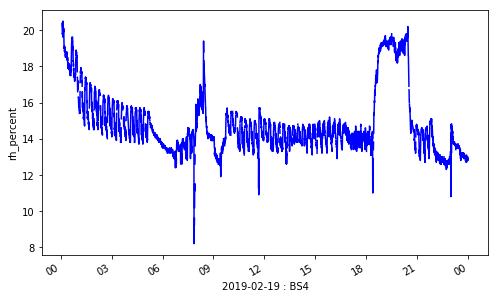

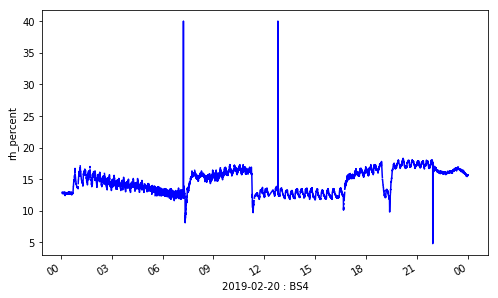

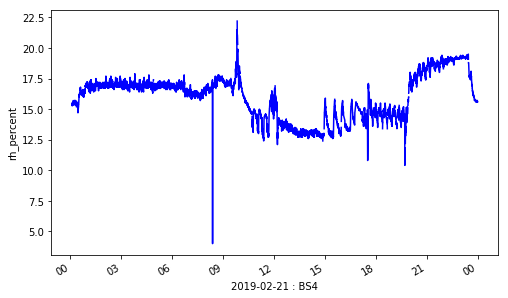

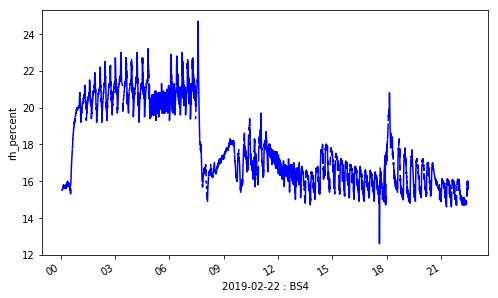

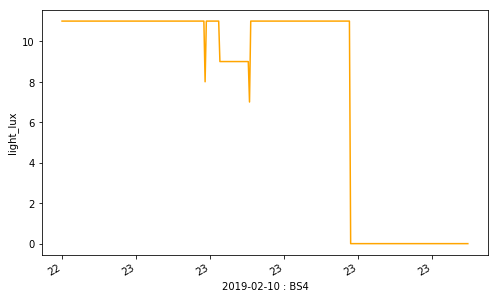

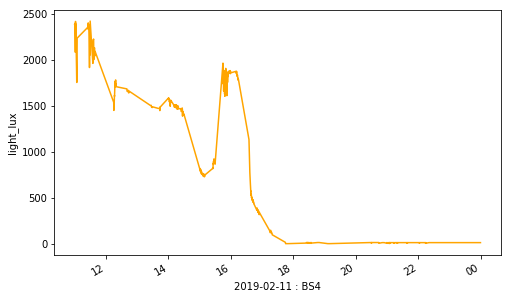

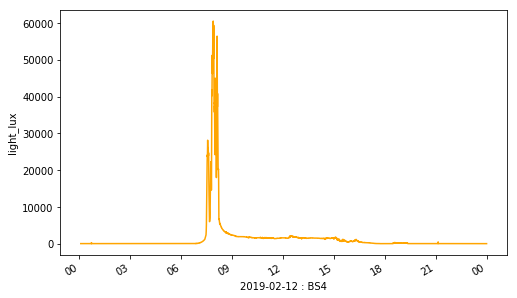

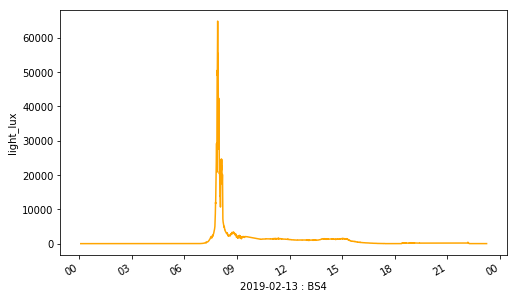

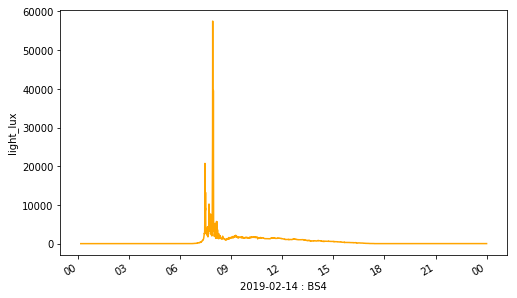

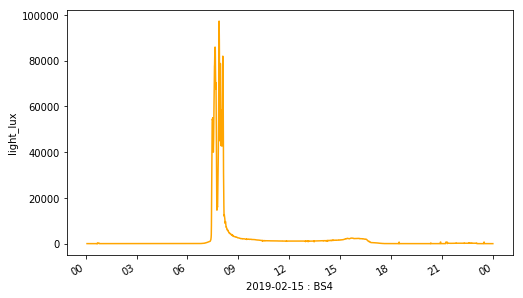

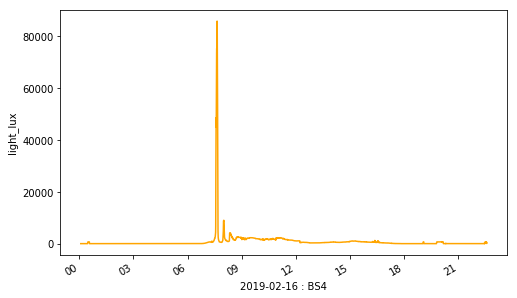

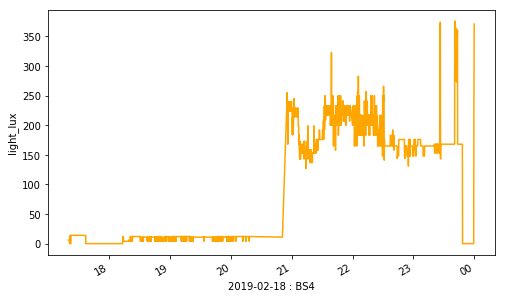

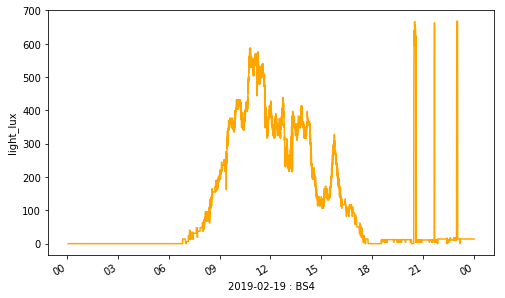

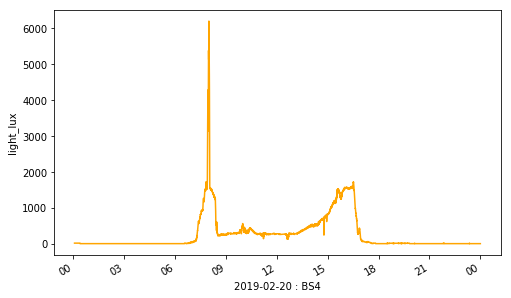

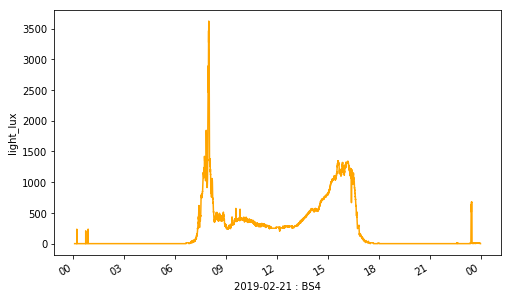

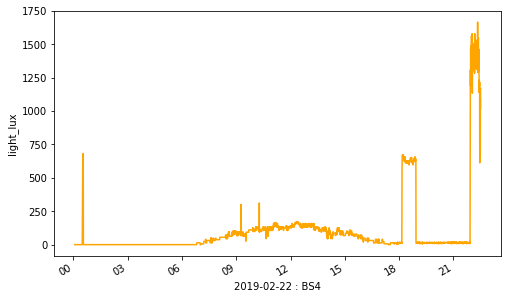

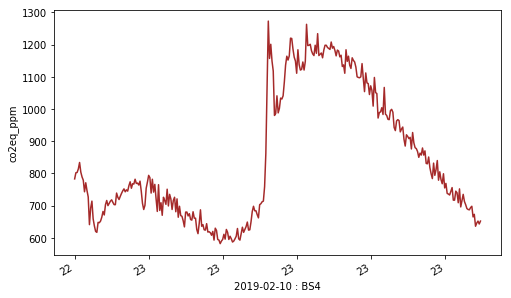

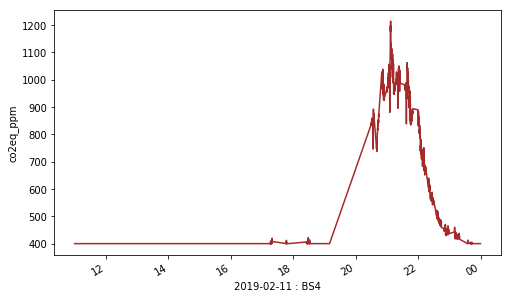

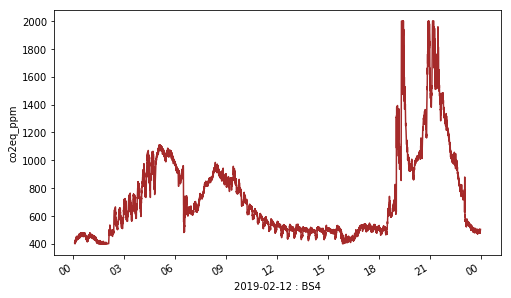

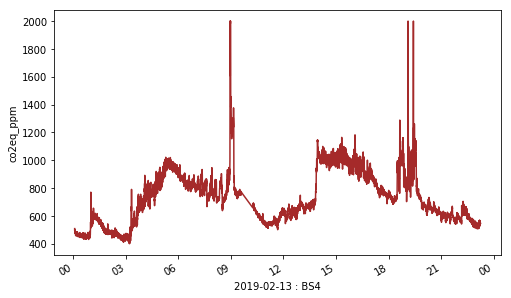

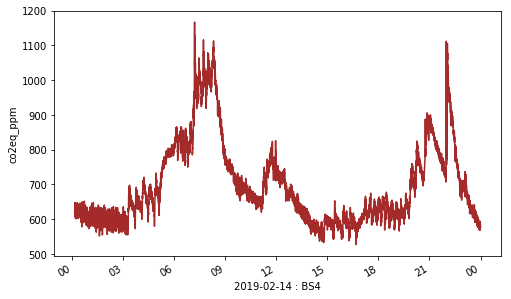

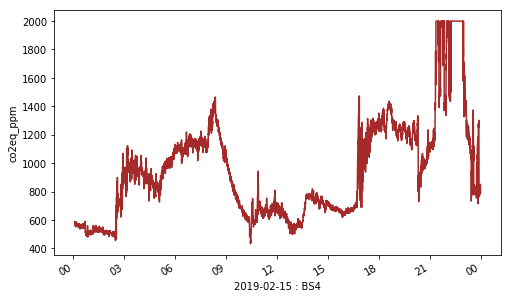

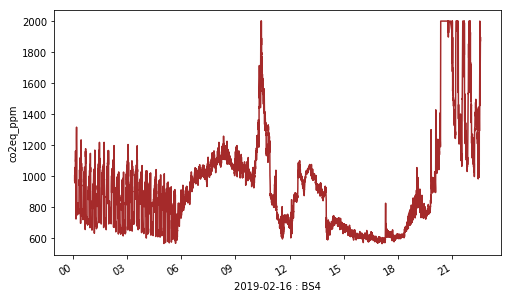

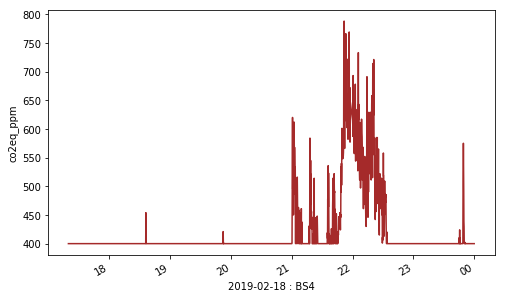

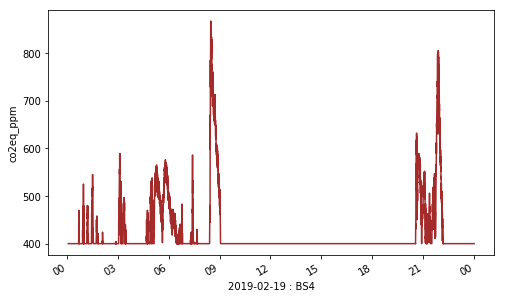

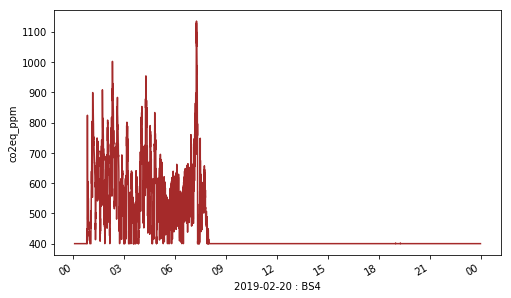

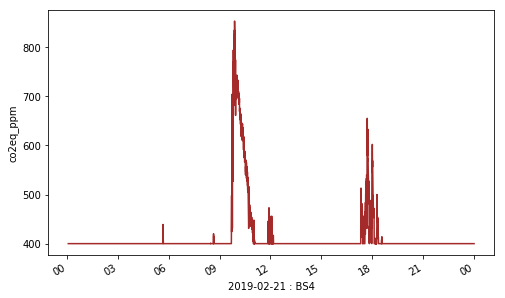

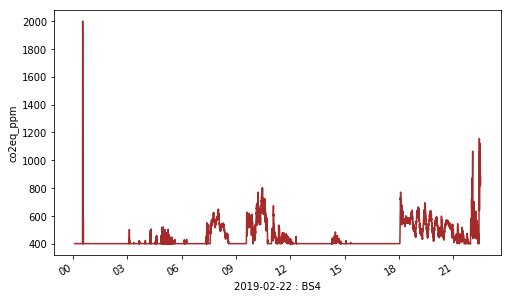

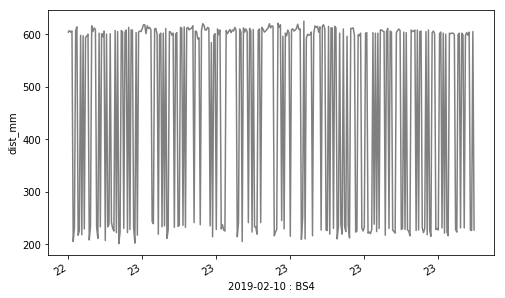

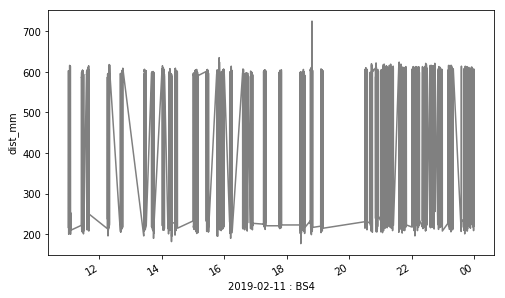

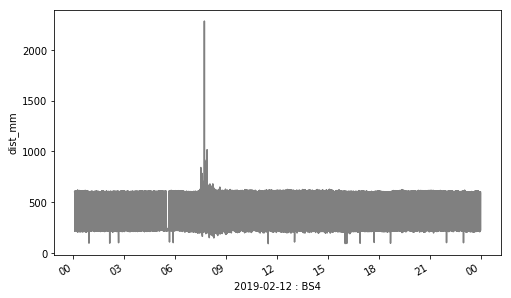

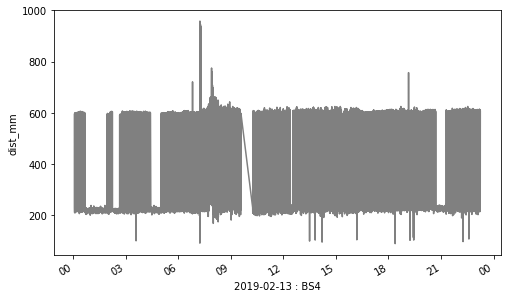

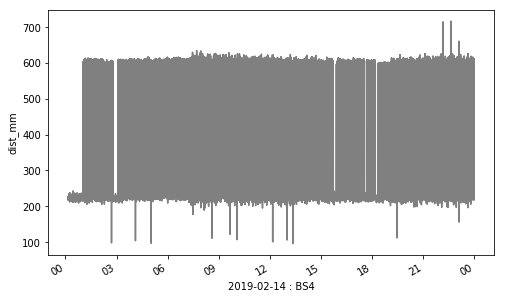

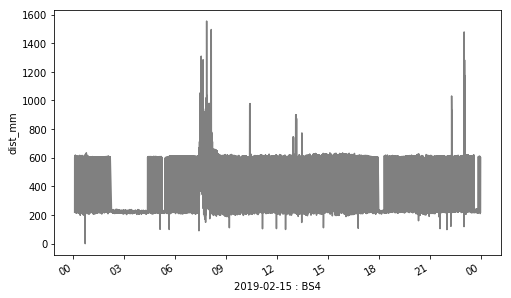

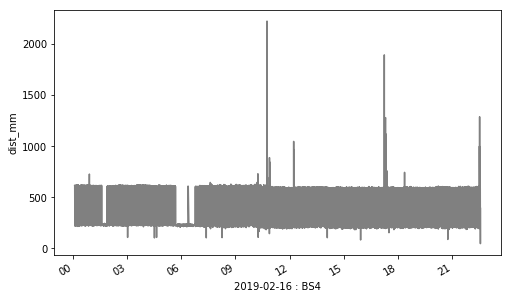

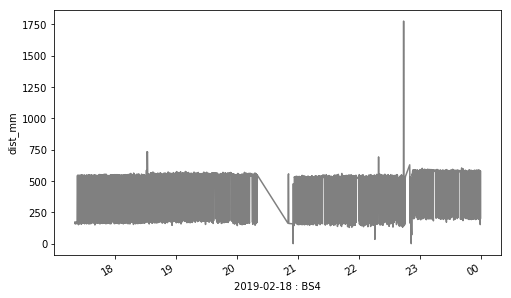

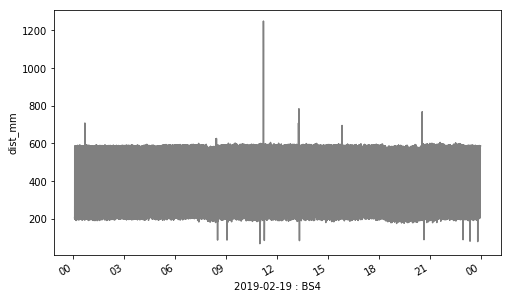

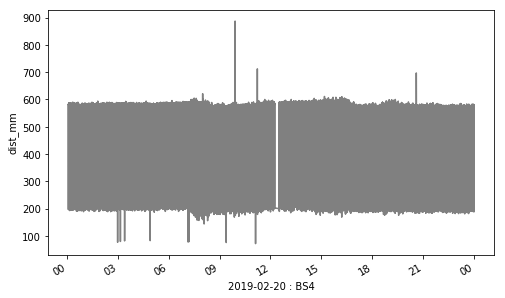

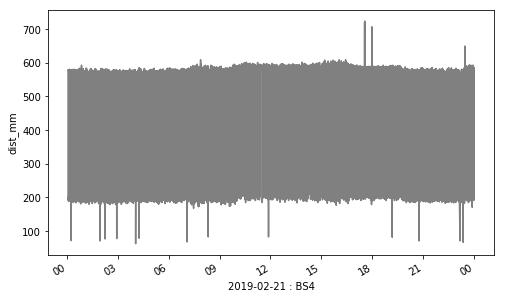

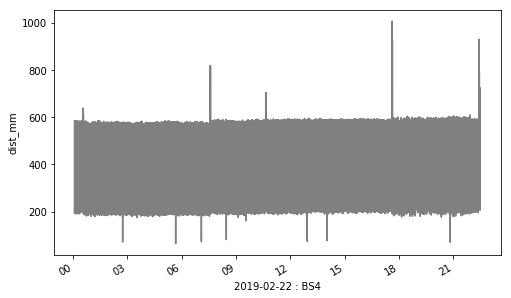

In [56]:
measures_to_plot = ['tvoc_ppb','temp_c','rh_percent','light_lux','co2eq_ppm','dist_mm']
#measures_to_plot = ['temp_c']
max_min = {'temp_c': [20, 30], 'rh_percent': [0,40], 'tvoc_ppb':[0,2000], 'co2eq_ppm':[0,2000]}

colors = ['green', 'red', 'blue', 'orange', 'brown', 'grey']

G = PlottingData(all_dfs, measures_to_plot, max_min, colors)

G.main()


temp_c
<class 'pandas.core.series.Series'>


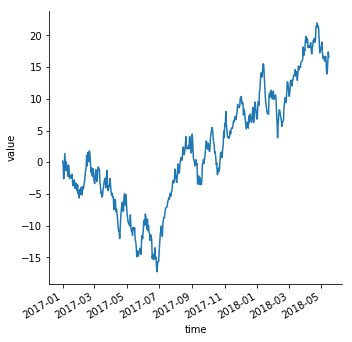

In [18]:
measures_to_plot = ['tvoc_ppb','temp_c','rh_percent','light_lux','co2eq_ppm','dist_mm']
m = measures_to_plot[1]
print(m)
df = pd.DataFrame(dict(time=pd.date_range("2017-1-1", periods=500),
                       value=np.random.randn(500).cumsum()))
g = sns.relplot(x="time", y="value", kind="line", data=df)
g.fig.autofmt_xdate()

print(type(df['time']))

In [13]:
## to do:
# attach house number by breaking off of title
# add maggie occupancy status
# split up date/time columns
# write by day
# check each time point
# add start/end???

test = "this is a test string"
new = test.replace("this", "that").replace("is", "was")
#print(new)

# dataset analytics
number and percent of missing data values (nans)
percent of captured data points


In [668]:
dates = ['2019-02-12','2019-02-13']
#sensors = ['BS6', 'BS5', 'BS4', 'BS3', 'BS2', 'BS1']
sensors = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6']
start_path = '/Users/maggie/Desktop/HPD_mobile/HPD_csv/'

all_dfs = {}
num_nans = {}

#reading in csv files and writing as dataframes
for sensor in sensors:
    frames = []
    for date in dates:
        end_path = os.path.join(start_path, str(sensor + '-' + date + '.csv'))
        df = pd.read_csv(end_path)
        datetime_col = df['time'].str.split('T', n = 1, expand = True)
        df.insert(loc = 0, column = 'time_hour', value = datetime_col[1].str.replace('Z',''))
        df.insert(loc = 0, column = 'date', value = datetime_col[0])
        df = df.drop(columns = ['time', 'Unnamed: 0'])
        df = df.sort_values(by = ['date', 'time_hour'])
        frames.append(df)
                
    name = str(sensor)
    sensor_df = pd.concat(frames, ignore_index = True)
    na_counts = sensor_df.isnull().sum()
    num_nans[sensor] = na_counts
        
    all_dfs[name] = sensor_df 
    test_df = sensor_df

FileNotFoundError: File b'/Users/maggie/Desktop/HPD_mobile/HPD_csv/BS1-2019-02-12.csv' does not exist

In [92]:
percent_nans = {}

for df in all_dfs: 
    frame = all_dfs[df]
    end = frame['time_hour'].tail(1)
    perc = num_nans[df]/len(frame)
    high = 100 * perc.max()
    percent_nans[df] = high
print(percent_nans)

{'BS6': 4.722651554181693, 'BS5': 4.993673555461831, 'BS4': 5.2768021408262245, 'BS3': 5.055476766497039, 'BS2': 4.773703336636935, 'BS1': 30.87160108436704}


In [85]:
print(num_nans)    


{'BS6': date            0
time_hour       0
tvoc_ppb        0
temp_c        550
rh_percent    550
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: int64, 'BS5': date            0
time_hour       0
tvoc_ppb        0
temp_c        592
rh_percent    592
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: int64, 'BS4': date            0
time_hour       0
tvoc_ppb        0
temp_c        631
rh_percent    631
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: int64, 'BS3': date            0
time_hour       0
tvoc_ppb        0
temp_c        606
rh_percent    606
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: int64, 'BS2': date            0
time_hour       0
tvoc_ppb        0
temp_c        578
rh_percent    578
light_lux       0
co2eq_ppm       0
dist_mm         0
tvoc_base       0
co2eq_base      0
dtype: i

In [770]:
print(all_dfs['BS1'])

                     time  tvoc_ppb  temp_c  rh_percent  light_lux  co2eq_ppm  \
32166 2019-02-13 00:05:00         0    24.1        14.7        0.0        400   
32167 2019-02-13 00:05:11         0     NaN         NaN        0.0        400   
32168 2019-02-13 00:05:20         0    24.1        14.7        0.0        400   
32169 2019-02-13 00:05:30         0    24.1        14.8        0.0        400   
32170 2019-02-13 00:05:41         0    24.1        14.8        0.0        400   
32171 2019-02-13 00:05:50         0    24.1        14.6        0.0        400   
32178 2019-02-13 00:06:01         0    24.1        14.7        0.0        400   
32179 2019-02-13 00:06:10         0     NaN         NaN        0.0        400   
32180 2019-02-13 00:06:21         0    24.1        14.9        0.0        400   
32181 2019-02-13 00:06:31         0    24.1        14.8        0.0        400   
32182 2019-02-13 00:06:40         0    24.1        14.9        0.0        400   
32183 2019-02-13 00:06:50   

Sensor Hub BS1


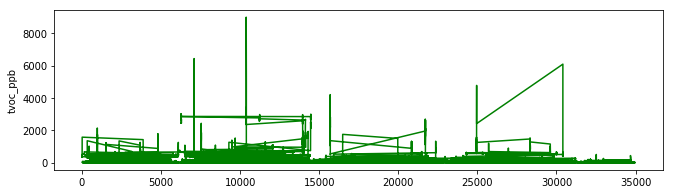

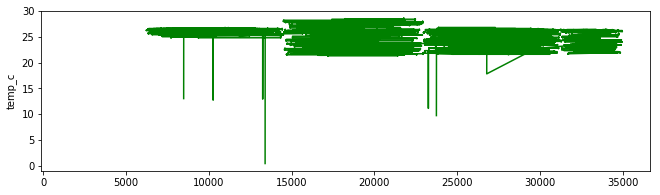

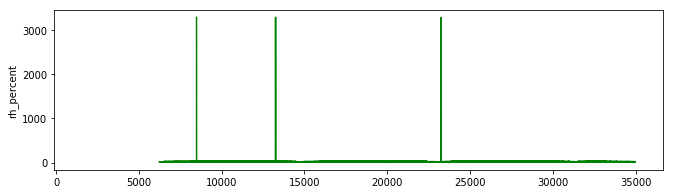

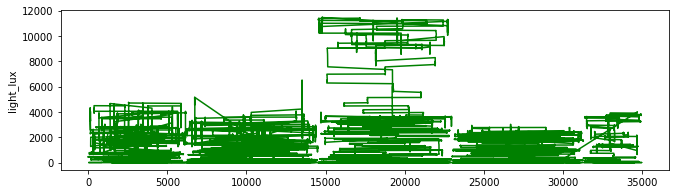

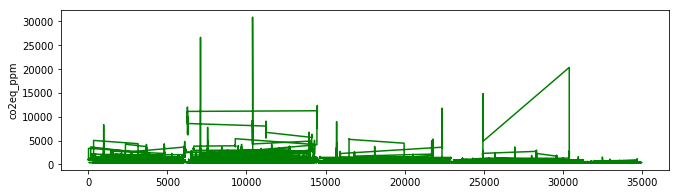

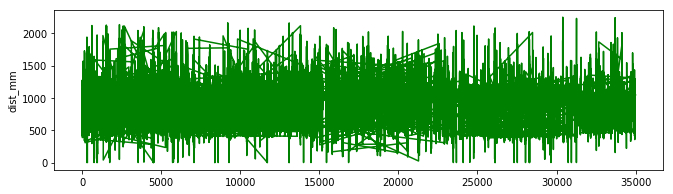

Sensor Hub BS2


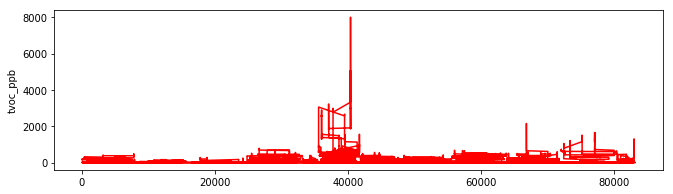

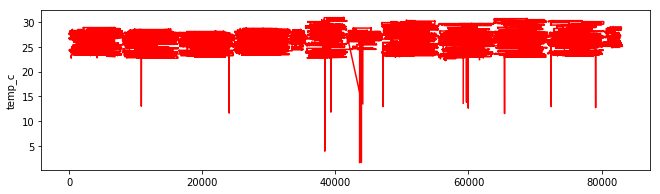

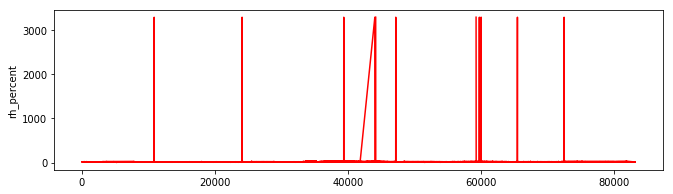

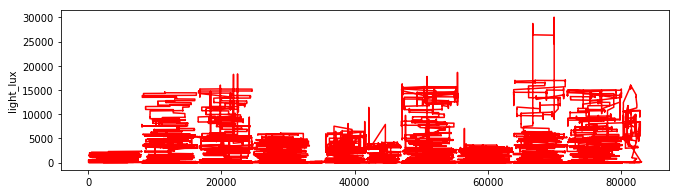

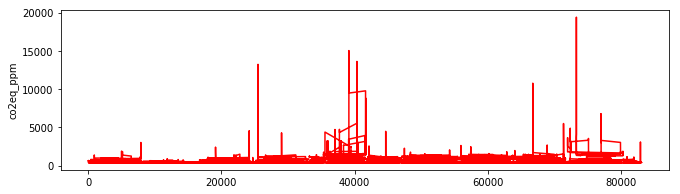

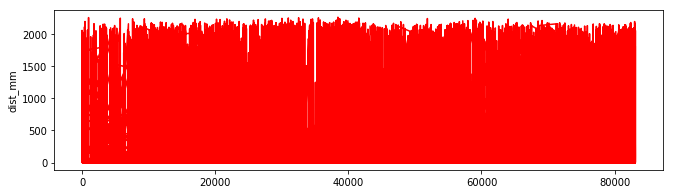

Sensor Hub BS3


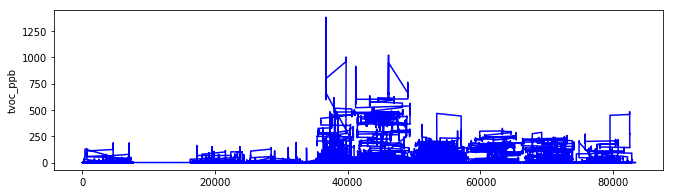

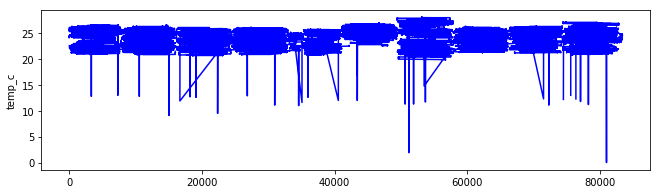

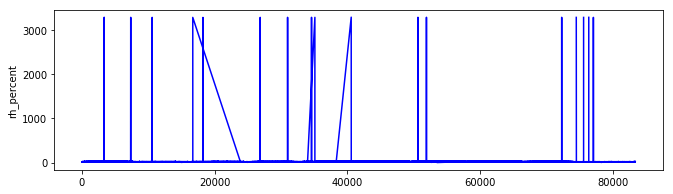

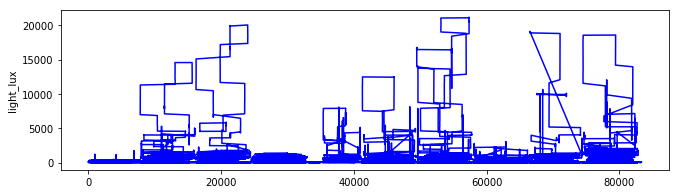

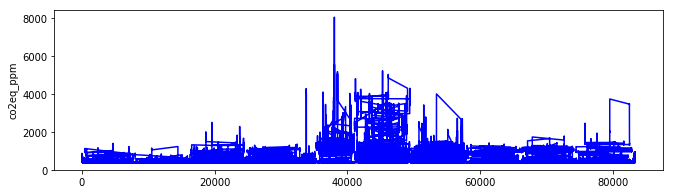

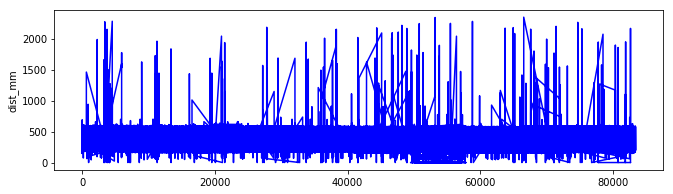

Sensor Hub BS4


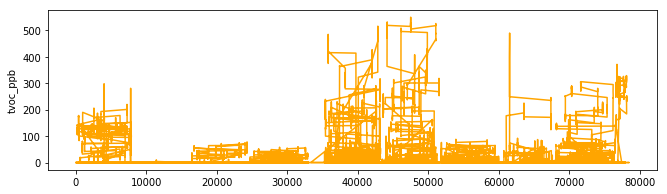

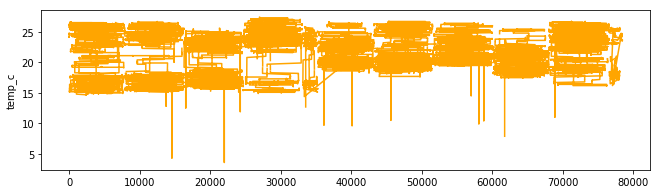

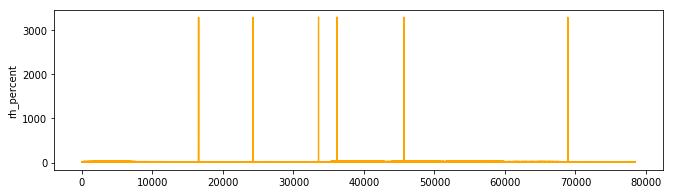

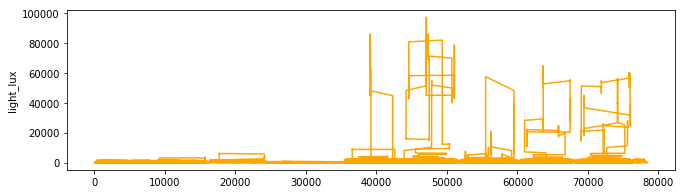

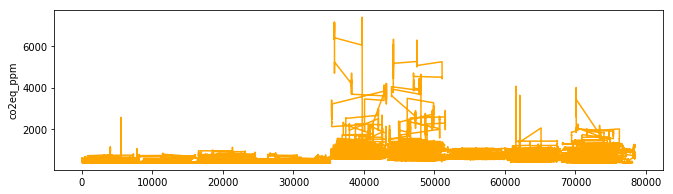

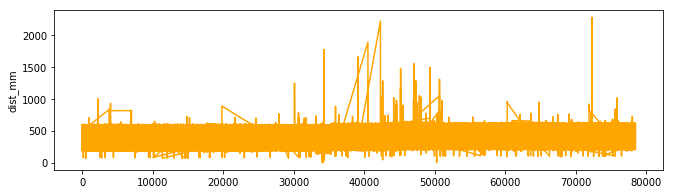

In [768]:
measures_to_plot = ['tvoc_ppb','temp_c','rh_percent','light_lux','co2eq_ppm','dist_mm']
colors = ['green', 'red', 'blue', 'orange', 'brown', 'grey']


for m, df in enumerate(all_dfs):
    print("Sensor Hub " + df)
    for n, measure in enumerate(measures_to_plot):
        plt.figure(figsize = (24,10))
        plt.subplot(3,2,n+1)

        plt.plot(all_dfs[df][measure], color = colors[m])
        if measure == 'rh_percent':
            plt.ylim = (0,100)
        plt.ylabel(measure)

        plt.savefig(df + ' - ' + measure)
    plt.show()  
